In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os, django
from geotext import GeoText

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from sklearn.manifold import TSNE
from scoping.models import *
from scoping.views import *
from tmv_app.views import *
import scipy.stats as st
import itertools

now=datetime.datetime.now()

django.db.connection.close()

In [2]:
q = Query.objects.get(pk=8843)
p = q.project
tags = q.tag_set.values('title')
print(tags)
dodf = (pd.DataFrame.from_dict(DocOwnership.objects.filter(query=q,relevant__gt=0)
                               .exclude(tag__title__icontains="representative")
                              .values('doc_id','id','relevant','user__username'))
       )
dodf.head()

<QuerySet [{'title': 'Probably relevant keyword sample 19'}, {'title': 'Probably relevant random sample 18'}, {'title': 'Probably relevant random sample 17'}, {'title': 'Probably relevant random sample 16'}, {'title': 'Probably relevant random sample 15'}, {'title': 'Probably relevant random sample 14'}, {'title': 'Probably relevant random sample 13'}, {'title': 'Probably relevant random sample 12'}, {'title': 'Representative random sample 5'}, {'title': 'Probably relevant random sample 11'}, {'title': 'Representative random sample 4'}, {'title': 'Probably relevant random sample 10'}, {'title': 'Representative random sample 3'}, {'title': 'Probably relevant random sample 9'}, {'title': 'Representative random sample 2'}, {'title': 'Probably relevant random sample 2'}, {'title': 'Probably relevant random sample 1'}, {'title': 'Random sample 1'}, {'title': 'Probably relevant random sample 8'}, {'title': 'Large representative random sample 2'}, '...(remaining elements truncated)...']>


,doc_id,id,relevant,user__username
0,2647339,1630937,3,galm
1,643753,1630944,1,galm
2,273713,1630951,1,galm
3,444393,1630958,1,galm
4,1727089,1630965,3,galm


In [3]:
order_df = (dodf[['doc_id','id']]
            .groupby('doc_id')
            .first()
            .sort_values('id')
            .reset_index()
            .reset_index()
            .rename(columns={"index":"order"})
            .drop(columns="id")
           )
order_df

,order,doc_id
0,0,2647339
1,1,643753
2,2,273713
3,3,444393
4,4,1727089
...,...,...
1865,1865,1866931
1866,1866,1832851
1867,1867,236181
1868,1868,527547


In [4]:

django.db.connection.close()

q = Query.objects.get(pk=8843)
p = q.project

dos = DocOwnership.objects.filter(tag__query__project=p, relevant__gt=0)

doc_ids = set(dos.values_list('doc__id',flat=True))

# Get relevant / not relevant decisions
do_df = pd.DataFrame.from_dict(
    dos.values('doc__id','doc__title','doc__content','user__username','relevant')
)
do_df.loc[do_df['relevant']==0,'val'] = np.NaN
do_df.loc[do_df['relevant']==1,'val'] = 1
do_df.loc[do_df['relevant']==2,'val'] = 0
do_df.loc[do_df['relevant']==3,'val'] = np.NaN
do_df.head()

# Get category assignment
cats = Category.objects.filter(project=p).exclude(name__icontains="hidden>")
df = pd.DataFrame.from_dict(
    DocUserCat.objects.filter(
        category__in=cats,
        doc__in=doc_ids
    ).values(
        'doc__id',
        'doc__title',
        'doc__content',
        'category__name',
        'category__level',
        'user__username',
        'countries__name',
        'texts__name',
        'selection_tier'
    )
)
# Filter so that it matches the relevant set
df = df[
    (df[['doc__id','user__username']].apply(tuple, axis=1).isin(do_df[['doc__id','user__username']].apply(tuple, axis=1))) | 
    (df['user__username']=="Auto")
]

# Rename category to capture level
df['category__level'] = df['category__level'].astype(str)
df['Category Name'] = df[['category__level','category__name']].apply(lambda x: ' - '.join(x), axis=1)
#df['cat'] = df[['category__level','category__name','user__username']].apply(lambda x: ' - '.join(x), axis=1)

# Capture the primary/secondary value (1 for primary, 2 for secondary)
df['val'] = df['selection_tier']

# Set the value to the country / text where appropriate and j
df.loc[~pd.isna(df['countries__name']),'val'] = df.loc[~pd.isna(df['countries__name']),'countries__name']
df.loc[~pd.isna(df['texts__name']),'val'] = df.loc[~pd.isna(df['texts__name']),'texts__name']

cats = df['Category Name'].unique()

df.head()

# Merge relevant/not relevant with categories
do_df['Category Name'] = "0 - relevant"

df = pd.concat([
    df[['doc__id','doc__title','doc__content','user__username','Category Name','val']],
    do_df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
])
df.tail()

,doc__id,doc__title,doc__content,user__username,Category Name,val
5630,1838661,Cultural and Social Elements in the Developmen...,In the context of climate change and energy cr...,doebbeling@mcc-berlin.net,0 - relevant,0
5631,315555,"GLOBAL EXPERIMENTALIST GOVERNANCE, INTERNATION...",Global experimentalist governance has emerged ...,galm,0 - relevant,1
5632,1799426,"Underdetermination, Model-ensembles and Surpri...",As climate policy decisions are decisions unde...,galm,0 - relevant,1
5633,3827028,Establishment a recycled green building materi...,This study modifies a dynamic computable gener...,vasudevan@mcc-berlin.net,0 - relevant,1
5634,3827028,Establishment a recycled green building materi...,This study modifies a dynamic computable gener...,galm,0 - relevant,1


In [5]:
# fill tag values with 0s where they have been rated
dudf_wide = (df[['doc__id','doc__title','doc__content','user__username','Category Name','val']]
             .pivot_table(index=['doc__id','doc__title','doc__content','user__username'],columns="Category Name", values="val", aggfunc=np.sum)
             #.fillna(0)
            ).reset_index()

cats = [x for x in cats if x in dudf_wide.columns]

dudf_wide[cats] = dudf_wide[cats].fillna(0)

policy_columns=[x for x in dudf_wide.columns if re.match("^3",x)]
include_policy_columns = [x for x in policy_columns if "not policy related" not in x.lower() and "broader" not in x.lower()]
print(policy_columns)
post_policy_columns=[x for x in dudf_wide.columns if re.match("^[4-9]",x) or re.match("^[0-9]{2}",x)]
dudf_wide.loc[dudf_wide['3 - 0. Not policy related']==1,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[policy_columns].sum(axis=1,min_count=1)==0,post_policy_columns] = np.NaN
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)>0,"INCLUDE"] = 1
dudf_wide.loc[dudf_wide[include_policy_columns].sum(axis=1,min_count=1)==0,"INCLUDE"] = 0
dudf_wide

df = dudf_wide.melt(id_vars=['doc__id','doc__title','doc__content','user__username'])

df['value'] = df['value'].replace(2,1)

df



['3 - 0. Not policy related', '3 - 1. Analysis of an existing policy / concrete proposal', '3 - 2. Analysis of a generic policy', '3 - 3. Broader governance and policy']


,doc__id,doc__title,doc__content,user__username,Category Name,value
0,156,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,Magma power is the production of electricity f...,ceposadap@gmail.com,0 - relevant,1
1,156,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,Magma power is the production of electricity f...,edmondson@hertie-school.org,0 - relevant,1
2,337,Energy forecast till 2020 for the German Gover...,A study conducted by the Prognos economic rese...,ceposadap@gmail.com,0 - relevant,1
3,337,Energy forecast till 2020 for the German Gover...,A study conducted by the Prognos economic rese...,lucy.banisch@icloud.com,0 - relevant,1
4,921,Ontology engineering in provenance enablement ...,The National Climate Assessment of the U.S. Gl...,doebbeling@mcc-berlin.net,0 - relevant,1
...,...,...,...,...,...,...
564565,3878364,Occupants' Awareness of and Satisfaction with ...,With growing awareness of the need to reduce g...,vasudevan@mcc-berlin.net,INCLUDE,1
564566,3878440,Urban consumers' willingness to pay for higher...,Rapid urbanization poses accelerating pressure...,ceposadap@gmail.com,INCLUDE,1
564567,3878440,Urban consumers' willingness to pay for higher...,Rapid urbanization poses accelerating pressure...,edmondson@hertie-school.org,INCLUDE,0
564568,3878516,Life cycle greenhouse gas impacts of a connect...,"As technological advancements progress, the au...",ceposadap@gmail.com,INCLUDE,0


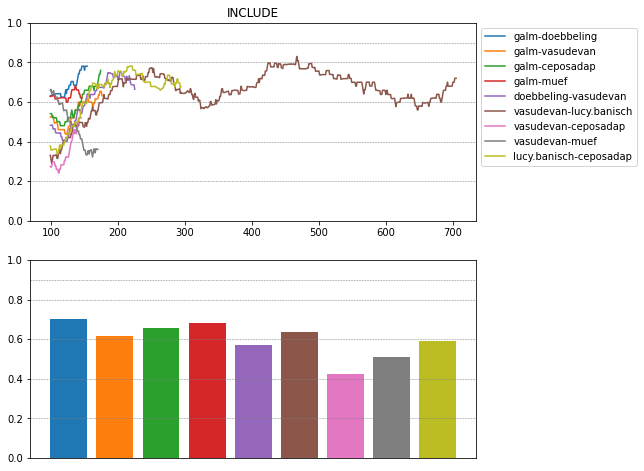

In [6]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "INCLUDE"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

def pairwise_agreement(df, pairs, c, axs, window):
    axs[0].set_title(c)
    df[df['Category Name']==c].dropna()
    i = 0
    cks = []
    pair_labels = []
    for p in pairs:
        d1 = df[(df['user__username']==p[0]) & (df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
        d2 = df[(df['user__username']==p[1]) & (df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

        pdf = (d1.merge(d2,how="inner")
               .merge(order_df,left_on="doc__id",right_on="doc_id")
               .sort_values('order')
               .reset_index(drop=True)
              )
        if pdf.shape[0]<window:
            continue
        else:
            pair_label = f"{p[0].split('@')[0]}-{p[1].split('@')[0]}"
            ckr = rolling_apply_ext(ckfunc, window, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
            axs[0].plot(ckr,label=pair_label)
            ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
            axs[1].bar(i,ck,label=pair_label)
            cks.append(ck)
            pair_labels.append(pair_label)
            i+=1
            
    axs[1].set_xticks([])
    for ax in axs:
        ax.set_ylim(0,1)
        for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
            ax.axhline(t,color="grey",ls="--",lw=0.5)

    axs[0].legend(bbox_to_anchor=(1,1))
    return cks, pair_labels
    
cks, pair_labels = pairwise_agreement(df, pairs, c, axs, 100)
plt.show()

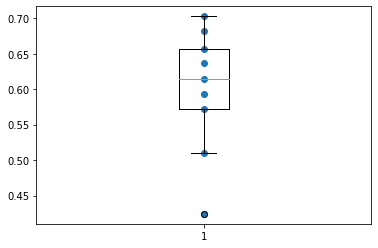

In [7]:
fig, ax = plt.subplots()
ax.boxplot(cks)
ax.scatter([1]*len(cks),cks)

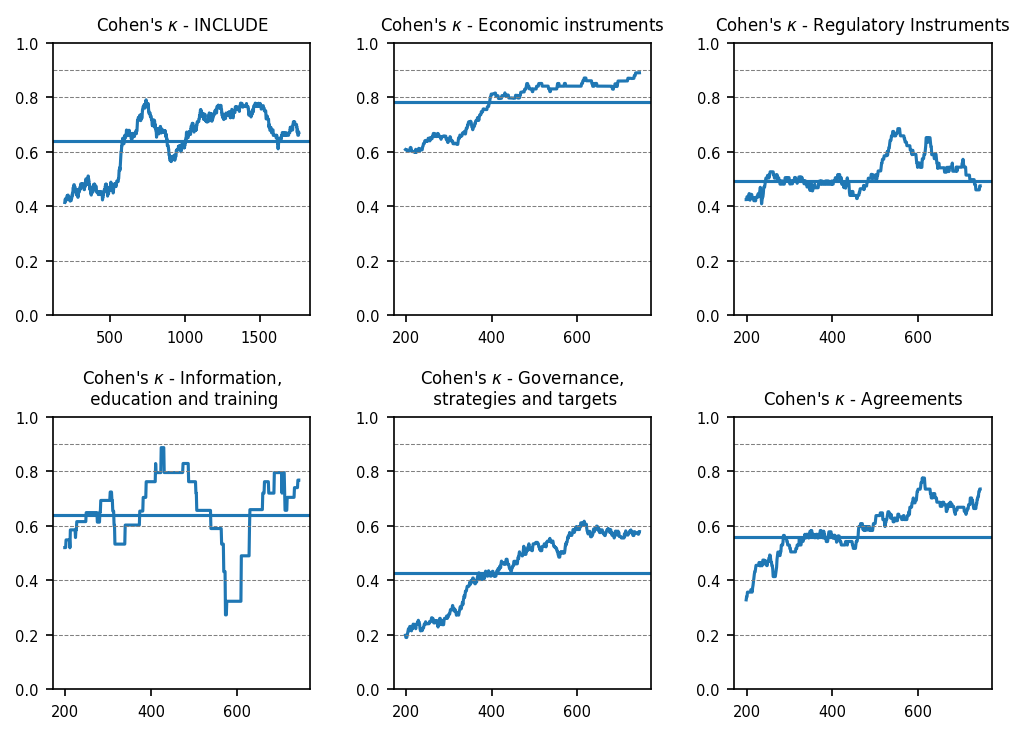

In [8]:
window = 200

fig = plt.figure(figsize=(7,5), dpi=150)

def total_ck(ax, df, c):
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .dropna()
    )
    ckr = rolling_apply_ext(ckfunc, window, pdf[0].astype(int).values, pdf[1].astype(int).values)
    ck = cohen_kappa_score(pdf[0].astype(int).values, pdf[1].astype(int).values)
    ax.plot(ckr)
    ax.axhline(ck)
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"Cohen's $\kappa$ - {c}", fontsize=8)
    
    
c1_cats = [x for x in df["Category Name"].unique() if re.match("^4",x)]

for i,c in enumerate(["INCLUDE"] + c1_cats):
    ax = fig.add_subplot(2,3,i+1)
    total_ck(ax, df, c)
    
fig.tight_layout()

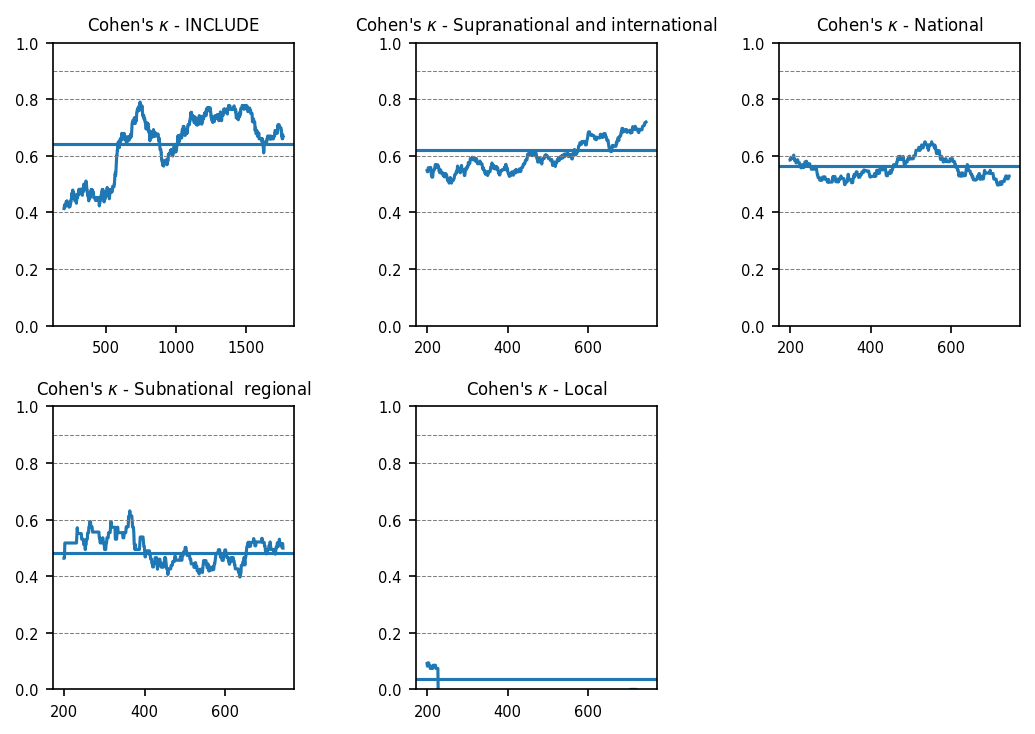

In [9]:
fig = plt.figure(figsize=(7,5), dpi=150)

sector_cats = [x for x in df["Category Name"].unique() if re.match("^7",x)]

for i,c in enumerate(["INCLUDE"] + sector_cats):
    ax = fig.add_subplot(2,3,i+1)
    total_ck(ax, df, c)
    
fig.tight_layout()

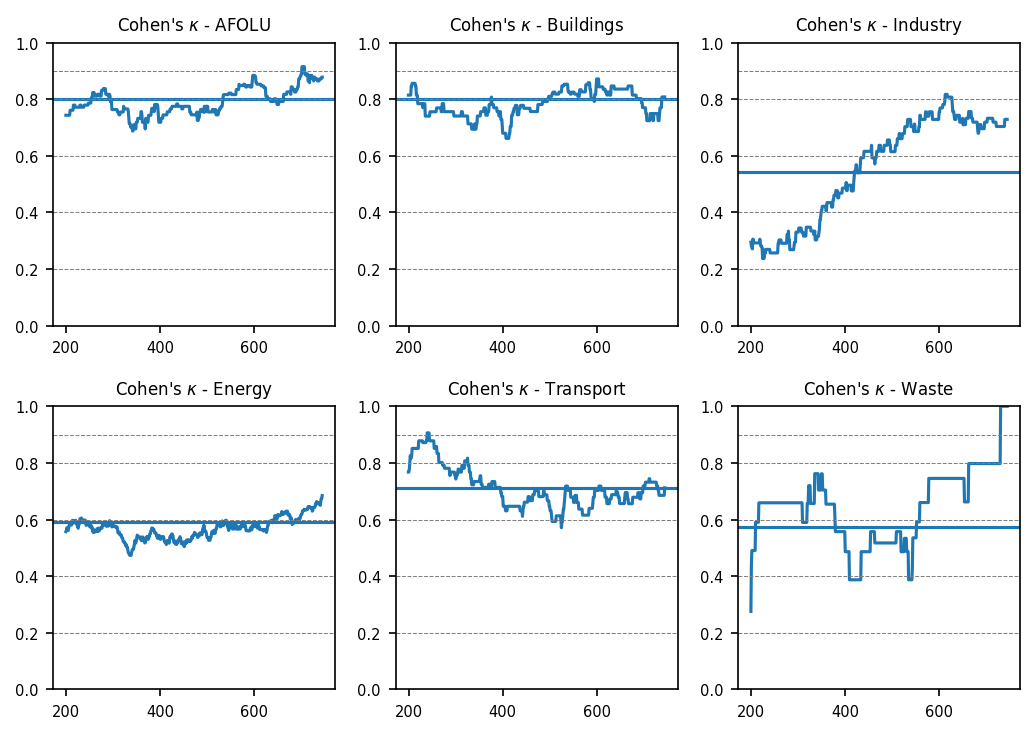

In [10]:
fig = plt.figure(figsize=(7,5), dpi=150)

sector_cats = [x for x in df["Category Name"].unique() if re.match("^8",x)][:6]

for i,c in enumerate(sector_cats):
    ax = fig.add_subplot(2,3,i+1)
    total_ck(ax, df, c)
    
fig.tight_layout()

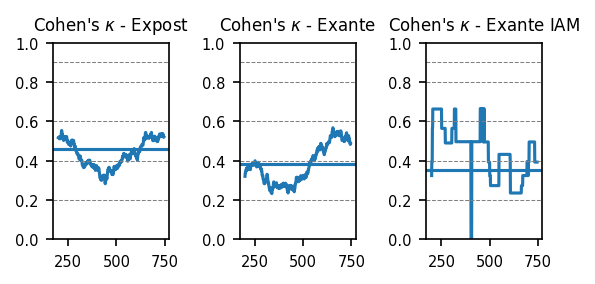

In [11]:
fig = plt.figure(figsize=(4,2), dpi=150)

cats = [x for x in df["Category Name"].unique() if re.match("^9",x)][:6]

for i,c in enumerate(cats):
    ax = fig.add_subplot(1,3,i+1)
    total_ck(ax, df, c)
    
fig.tight_layout()

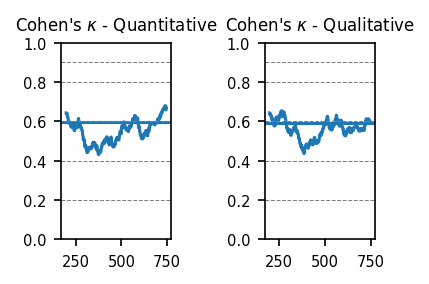

In [12]:
fig = plt.figure(figsize=(4,2), dpi=150)

cats = [x for x in df["Category Name"].unique() if re.match("^10",x)][:6]

for i,c in enumerate(cats):
    ax = fig.add_subplot(1,3,i+1)
    total_ck(ax, df, c)
    
fig.tight_layout()

In [13]:
master_df = pd.read_csv('data/0_labelled_documents.csv')

class args():
    pass
args.model_name = "allenai/scibert_scivocab_uncased"
args.model_name = "distilbert-base-uncased"
args.model_name = "climatebert__distilroberta-base-climate-f"
args.y_prefix = "4 -"
args.n_splits = 3
nonrandom = "_nonrandom"
   
df_len = 588
cols = [x for x in master_df.columns if re.match(f"^{args.y_prefix}",x)]

for c in cols:
    ct = c + " - prediction"
    master_df[ct] = np.NaN

for k in range(args.n_splits):
    yp = np.load(f"cluster-experiments/cv/df_{df_len}_y_preds{nonrandom}_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    ids = np.load(f"cluster-experiments/cv/df_{df_len}_y_pred{nonrandom}_ids_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    
    mdf = pd.DataFrame(yp)
    mdf.columns=[x + " - prediction" for x in cols]
    
    mdf['id'] = ids
    mdf = mdf.set_index('id')

    master_df = master_df.set_index("id")
    master_df.update(mdf)
    master_df = master_df.reset_index()
    
args.y_prefix = "INCLUDE"
df_len = 2512
cols = [x for x in master_df.columns if re.match(f"^{args.y_prefix}",x)]

nonrandom = ""

for c in cols:
    ct = c + " - prediction"
    master_df[ct] = np.NaN

for k in range(args.n_splits):
    yp = np.load(f"cluster-experiments/cv/df_{df_len}_y_preds{nonrandom}_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    ids = np.load(f"cluster-experiments/cv/df_{df_len}_y_pred{nonrandom}_ids_{args.y_prefix}_{args.model_name.replace('/','__')}_{k}.npy")
    
    mdf = pd.DataFrame(yp)
    mdf.columns=[x + " - prediction" for x in cols]
    
    mdf['id'] = ids
    mdf = mdf.set_index('id')

    master_df = master_df.set_index("id")
    master_df.update(mdf)
    master_df = master_df.reset_index()

master_df.head()

,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,9 - 2. Ex-ante (IAM),INCLUDE,representative_sample,representative_relevant,4 - 1. Economic instruments - prediction,4 - 2. Regulatory Instruments - prediction,"4 - 3. Information, education and training - prediction","4 - 4. Governance, strategies and targets - prediction",4 - 5. Agreements - prediction,INCLUDE - prediction
0,156,THE EXPECTED GREENHOUSE BENEFITS FROM DEVELOPI...,Magma power is the production of electricity f...,1.0,NaN,NaN,NaN,NaN,1.0,0.0,...,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,337,Energy forecast till 2020 for the German Gover...,A study conducted by the Prognos economic rese...,1.0,0.0,NaN,0,0,1.0,0.0,...,NaN,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,921,Ontology engineering in provenance enablement ...,The National Climate Assessment of the U.S. Gl...,1.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,1448,"Planning, governance and rural futures in Aust...",Rural regions in post-industrial countries con...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,3556,Will economic restructuring in China reduce tr...,We calculate carbon dioxide (CO2) emissions em...,1.0,1.0,NaN,China,NaN,1.0,0.0,...,0.0,1.0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
master_df[pd.notna(master_df['INCLUDE - prediction'])]

,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,9 - 2. Ex-ante (IAM),INCLUDE,representative_sample,representative_relevant,4 - 1. Economic instruments - prediction,4 - 2. Regulatory Instruments - prediction,"4 - 3. Information, education and training - prediction","4 - 4. Governance, strategies and targets - prediction",4 - 5. Agreements - prediction,INCLUDE - prediction
5,3679,Forcing and response in simulated 20th and 21s...,A simple methodology is applied to a transient...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.008296
6,3683,Egeson's (George's) transtridecadal weather cy...,"In the late 19th century, Charles Egeson, a ma...",0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.013713
10,5459,Vegetation structure and biodiversity along th...,The deep lateritic earths that cap the serpent...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.008301
15,10677,Permanent salt evaporation ponds in a semi-ari...,A change from planktonic to benthic primary pr...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.001802
17,12788,Consistent sampling methods for comparing mode...,We address the issue of how to compare atmosph...,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.002342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2563,3875963,Do actions speak louder than words? Comparing ...,"In this article, we empirically examine whethe...",0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.002379
2567,3876825,Understanding the origins and variability of t...,Background: Divergence in fuel consumption (FC...,1.0,NaN,NaN,0,0,1.0,0.0,...,NaN,1.0,1,1,NaN,NaN,NaN,NaN,NaN,0.026220
2571,3878125,Remote Sensing Applications in Monitoring of P...,Protected areas (PAs) have been established wo...,1.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.031307
2573,3878138,Assessing New Biotechnologies by Combining TEA...,An efficient use of biomass resources is a key...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,...,NaN,0.0,1,1,NaN,NaN,NaN,NaN,NaN,0.001956


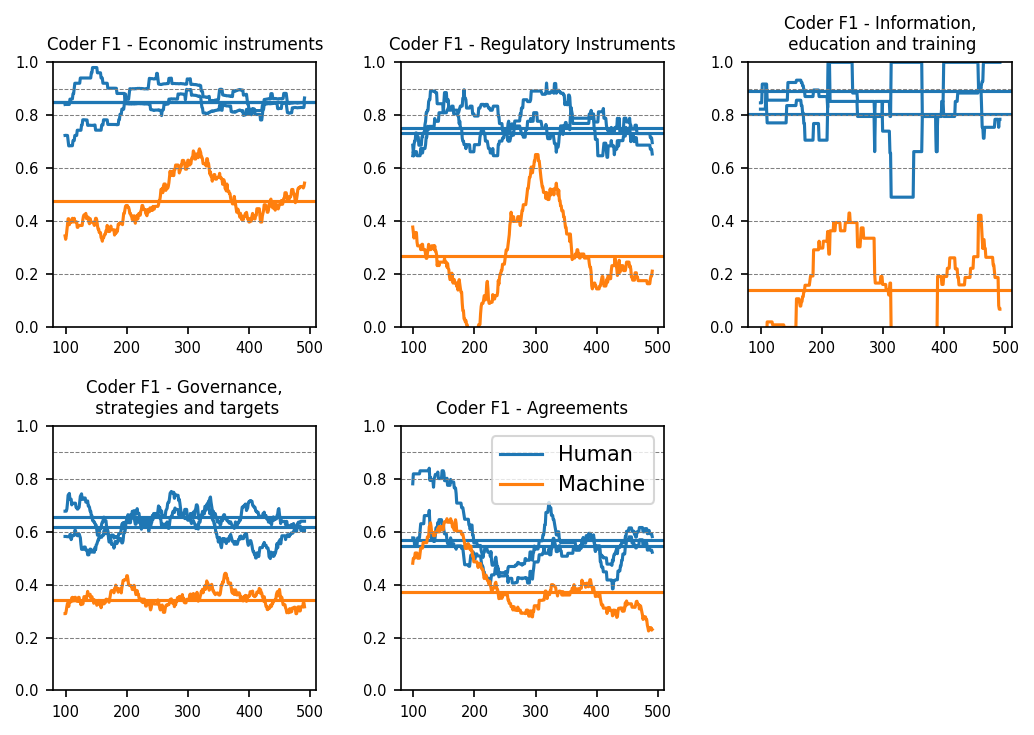

In [15]:
from sklearn.metrics import f1_score


window = 100

fig = plt.figure(figsize=(7,5), dpi=150)

def total_f1(ax, df, master_df, c):
    ct = c + " - prediction"
    f1func = lambda a1, a2: f1_score(a2,a1)
    df['coder'] = df.groupby(['doc__id','Category Name'])['value'].cumcount()
    pdf = df[df['Category Name']==c]
    pdf = (
        pdf[(pdf['coder']<2)]
        .pivot(index="doc__id",columns="coder",values="value").reset_index()
        .merge(order_df,left_on="doc__id",right_on="doc_id")
        .sort_values('order')
        .merge(master_df[['id',c,ct]],left_on='doc__id',right_on="id")
        .dropna()
    )
    for coder in [0,1]:
        if coder==0:
            label = "Human"
        else:
            label = None
        f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, pdf[coder].astype(int).values)
        f1 = cohen_kappa_score(pdf[c].astype(int).values, pdf[coder].astype(int).values)
        ax.plot(f1r, color="C0", label=label)
        ax.axhline(f1, color="C0")
    f1r = rolling_apply_ext(ckfunc, window, pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    f1 = cohen_kappa_score(pdf[c].astype(int).values, round(pdf[ct]).astype(int).values)
    ax.plot(f1r, color="C1", label="Machine")
    ax.axhline(f1, color="C1")
    ax.xaxis.set_tick_params(labelsize=7)
    ax.yaxis.set_tick_params(labelsize=7)
    
    ax.set_ylim(0,1)
    for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
        ax.axhline(t,color="grey",ls="--",lw=0.5)
        
    c = re.sub("[^a-zA-Z ,]","",c).strip().replace(',',',\n')
    
    ax.set_title(f"Coder F1 - {c}", fontsize=8)


for i,c in enumerate(c1_cats):
    ax = fig.add_subplot(2,3,i+1)
    total_f1(ax, df, master_df, c)
    
ax.legend()
    
fig.tight_layout()

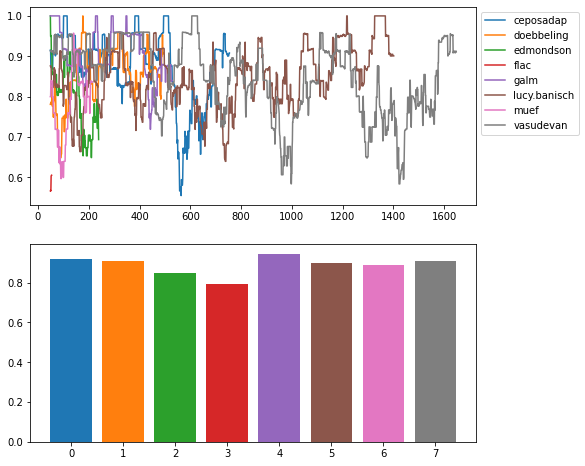

In [16]:
c = "INCLUDE"

fig, axs = plt.subplots(2,figsize=(8,8))

from sklearn.metrics import f1_score

f1func = lambda a1, a2: f1_score(a2,a1)

window = 50

f1s = []
i = 0
for name, group in df[df['Category Name']==c].groupby('user__username'):
    pdf = group.merge(master_df[['id',c]],left_on='doc__id',right_on="id").dropna()
    if pdf.shape[0]<window:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, window, pdf['value'].astype(int).values, pdf[c].astype(int).values)
        axs[0].plot(ckr,label=f"{name.split('@')[0]}")
        f1 = f1_score(pdf[c].astype(int).values,pdf['value'].astype(int).values)
        axs[1].bar(i,f1,label=f"{name.split('@')[0]}")
        f1s.append(f1)
        i+=1
    

axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

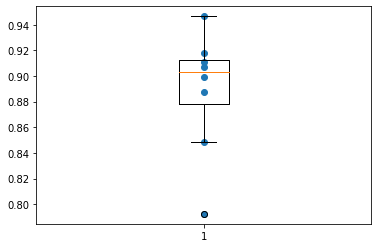

In [17]:
fig, ax = plt.subplots()

ax.boxplot(f1s)
ax.scatter([1]*len(f1s),f1s)

No handles with labels found to put in legend.


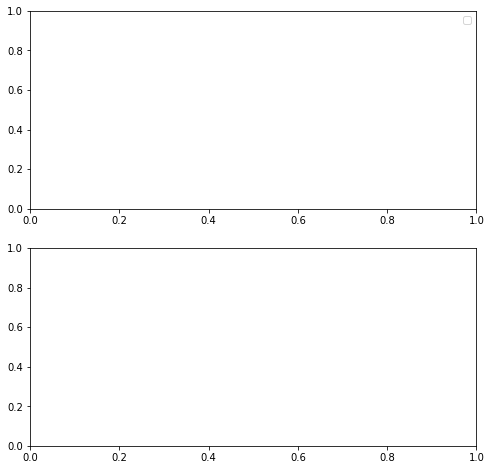

In [18]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "4 - 1. Economic instruments"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df[df['Category Name']==c].dropna()
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

No handles with labels found to put in legend.


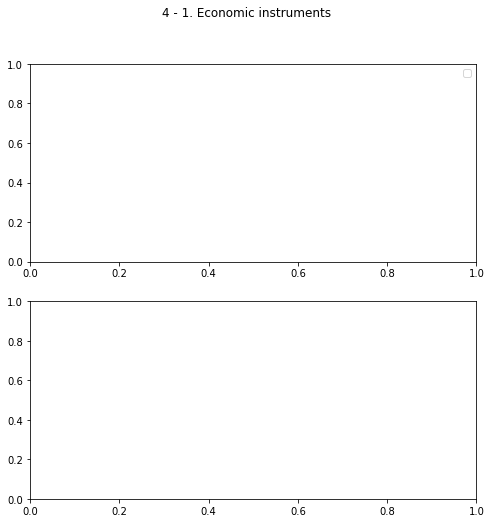

In [19]:
c = "4 - 1. Economic instruments"


sub_df = df[df['Category Name']==c].dropna()

fig, axs = plt.subplots(2,figsize=(8,8)) 

for p in pairs:

    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           #.fillna(1)
          )


    if pdf.shape[0]<50:
        continue
    else:

        ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)

        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)


axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No handles with labels found to put in legend.


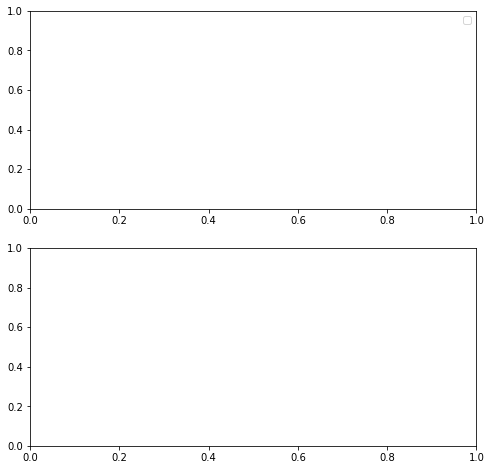

In [20]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "5 - 1.02. Carbon pricing"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.show()

No handles with labels found to put in legend.


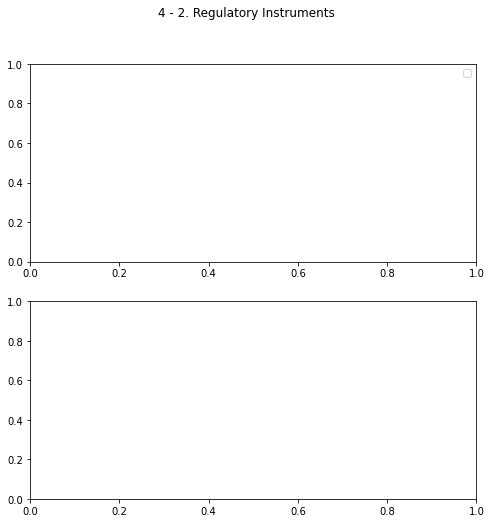

In [21]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs

c = "4 - 2. Regulatory Instruments"

from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

fig, axs = plt.subplots(2,figsize=(8,8))

i = 0

for p in pairs:
    sub_df = df
    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")
    
    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           .fillna(1)
          )

    if pdf.shape[0]<100:
        continue
    else:
        ckr = rolling_apply_ext(ckfunc, 100, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)
        
        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)
        
        
axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No handles with labels found to put in legend.


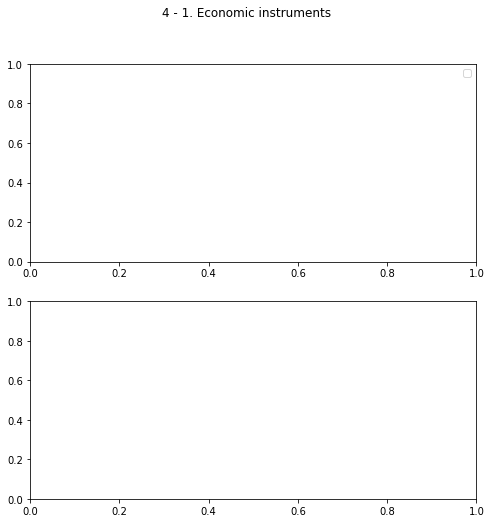

In [22]:
c = "4 - 1. Economic instruments"


sub_df = df[df['Category Name']==c].dropna()



fig, axs = plt.subplots(2,figsize=(8,8)) 

for p in pairs:

    d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
    d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

    pdf = (d1.merge(d2,how="inner")
           .merge(order_df,left_on="doc__id",right_on="doc_id")
           .sort_values('order')
           .reset_index(drop=True)
           #.fillna(1)
          )


    if pdf.shape[0]<50:
        continue
    else:

        ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
        axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        ck = cohen_kappa_score(pdf[p[0]].astype(int).values,pdf[p[1]].astype(int).values)
        axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
        i+=1
        axs[0].set_ylim(-1,1)

        for ax in axs:
            ax.set_ylim(0,1)
            for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                ax.axhline(t,color="grey",ls="--",lw=0.5)


axs[0].legend(bbox_to_anchor=(1,1))
plt.suptitle(c)
plt.show()

No handles with labels found to put in legend.


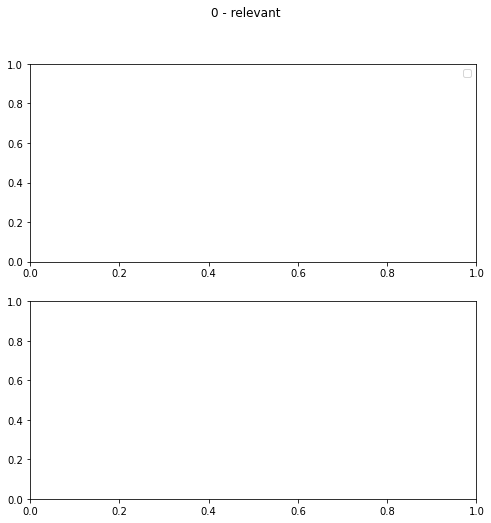

No handles with labels found to put in legend.


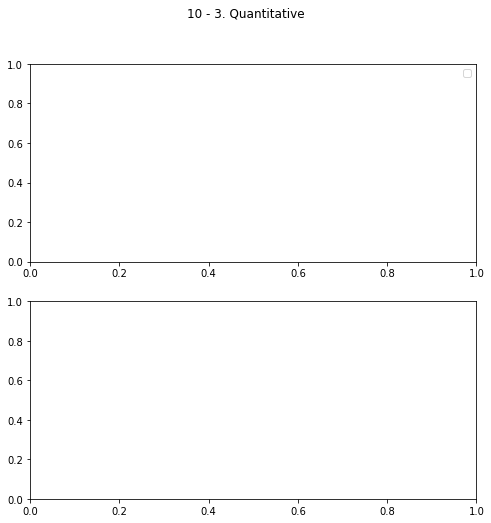

No handles with labels found to put in legend.


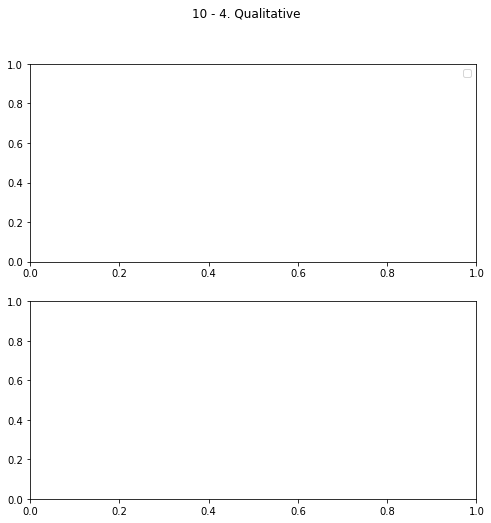

11 - countries
12 - policy name


No handles with labels found to put in legend.


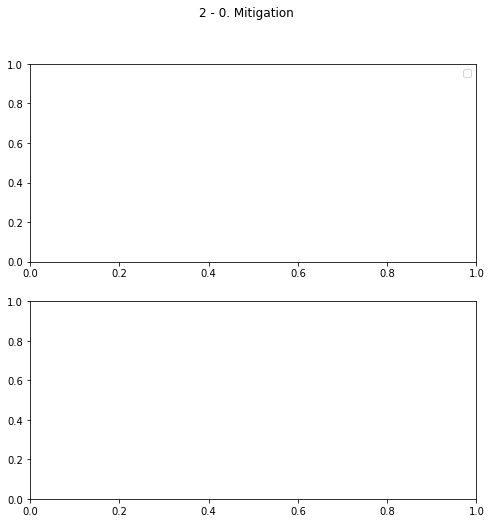

No handles with labels found to put in legend.


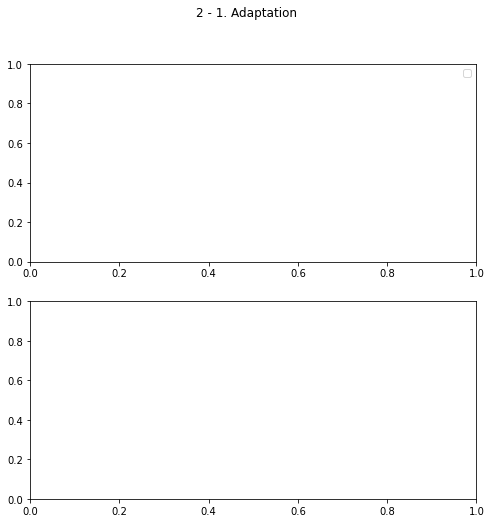

No handles with labels found to put in legend.


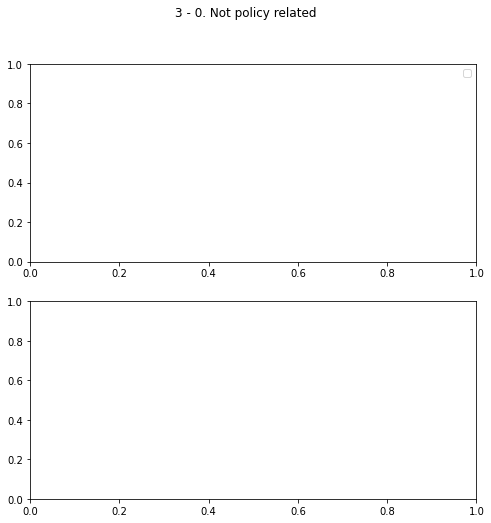

No handles with labels found to put in legend.


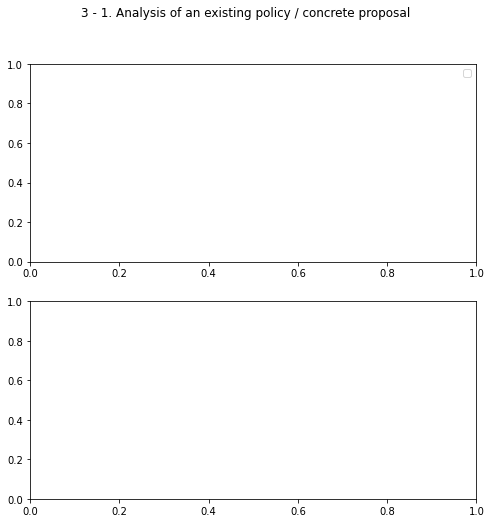

No handles with labels found to put in legend.


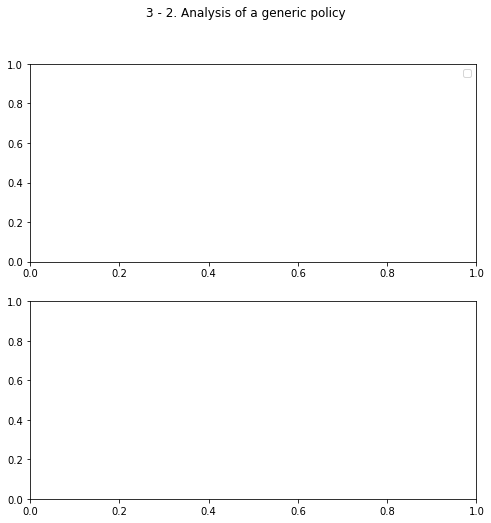

No handles with labels found to put in legend.


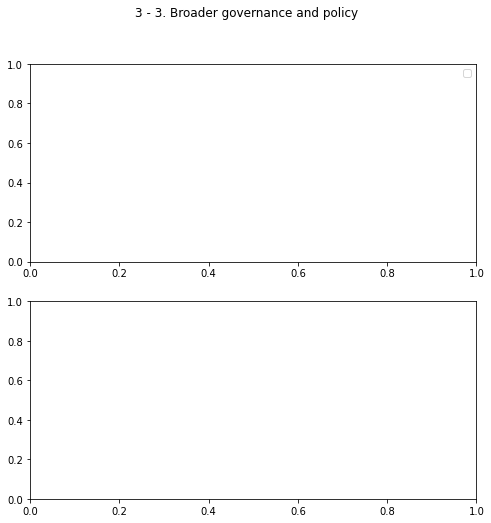

No handles with labels found to put in legend.


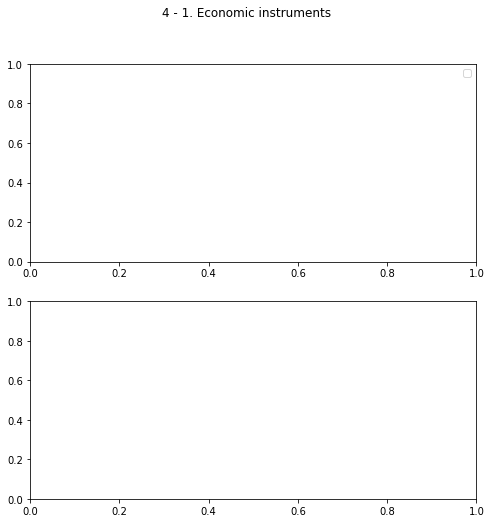

No handles with labels found to put in legend.


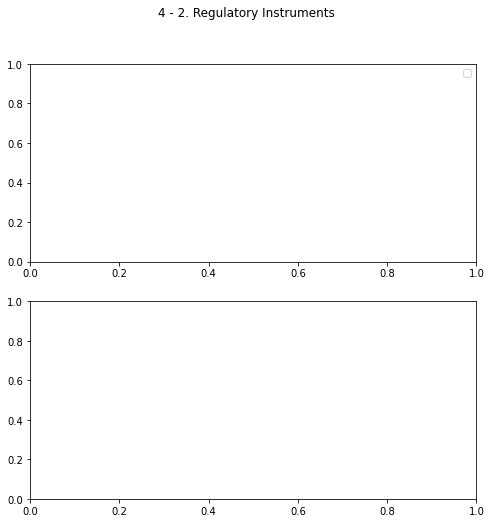

No handles with labels found to put in legend.


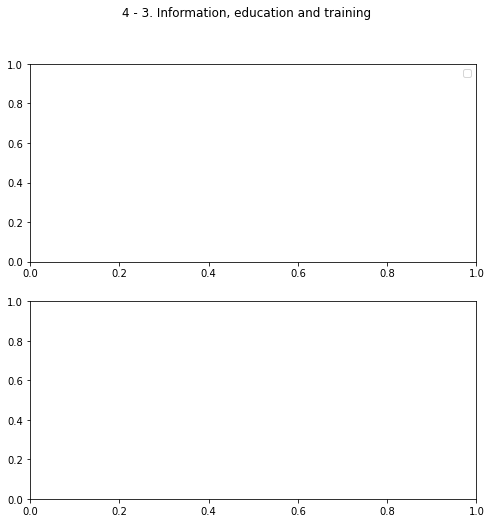

No handles with labels found to put in legend.


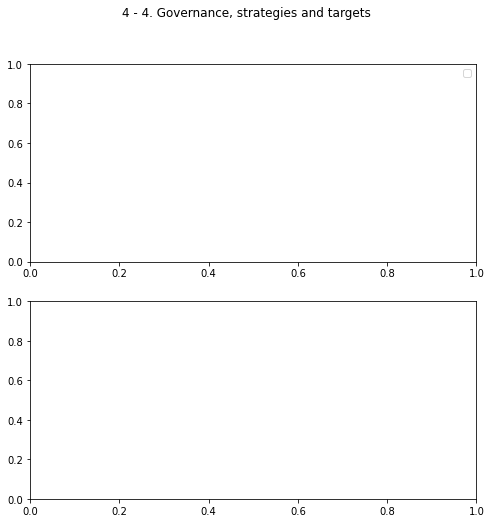

No handles with labels found to put in legend.


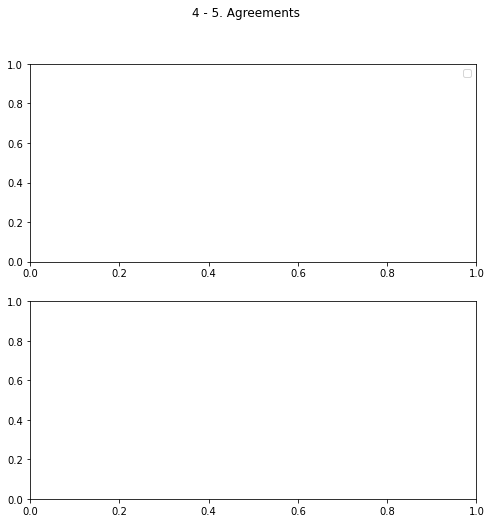

No handles with labels found to put in legend.


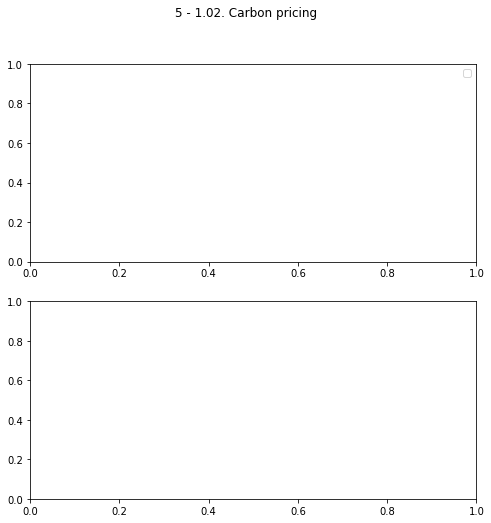

No handles with labels found to put in legend.


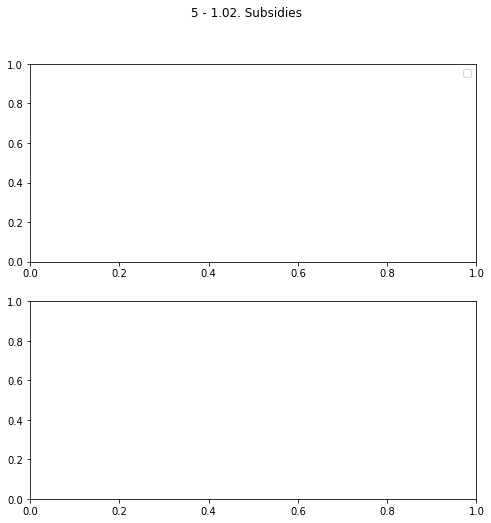

No handles with labels found to put in legend.


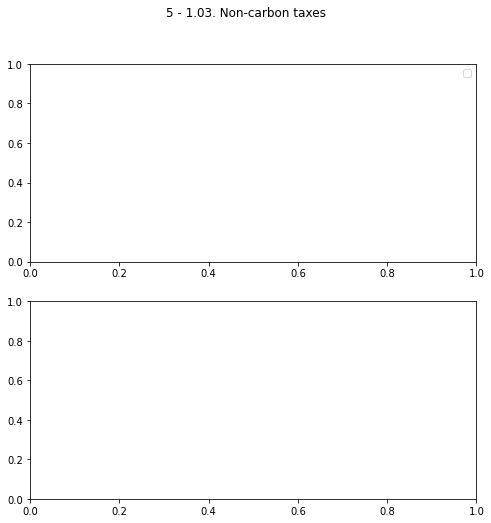

No handles with labels found to put in legend.


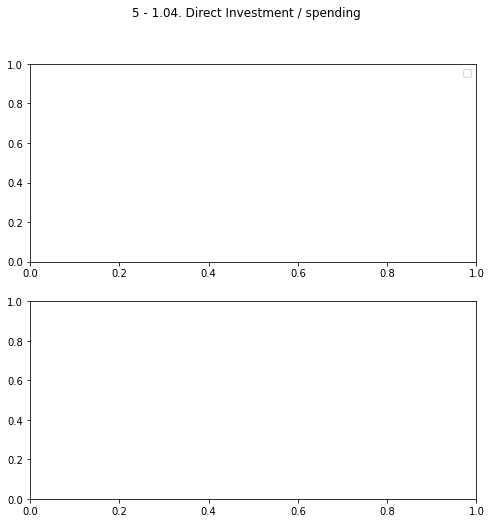

No handles with labels found to put in legend.


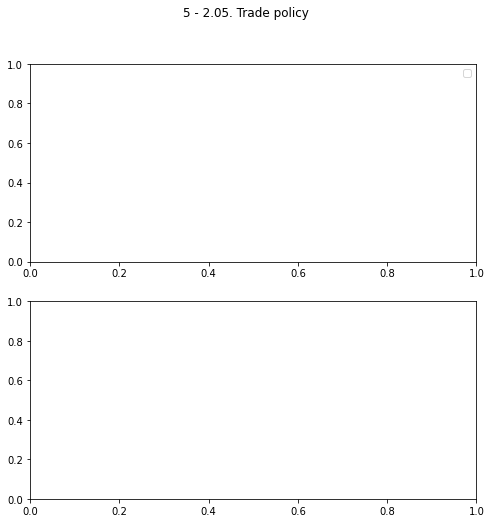

No handles with labels found to put in legend.


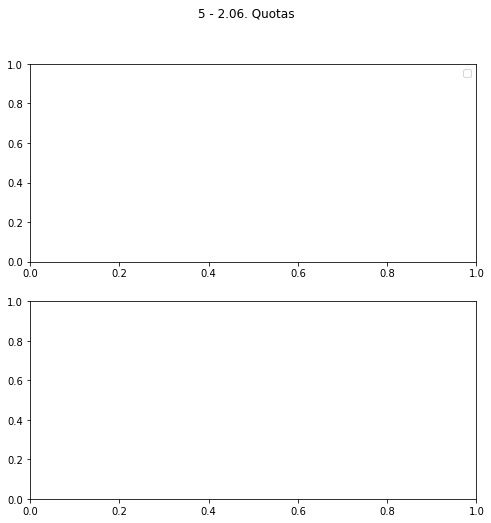

No handles with labels found to put in legend.


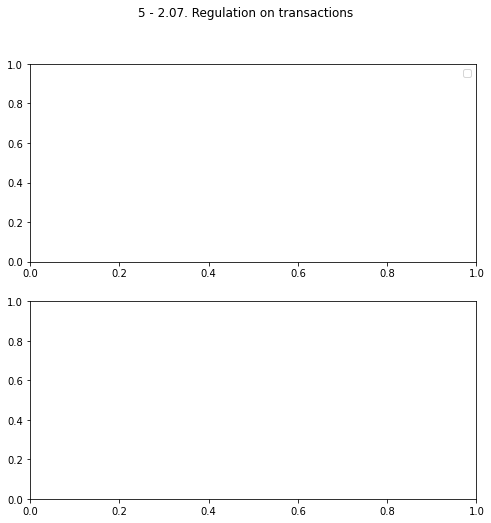

No handles with labels found to put in legend.


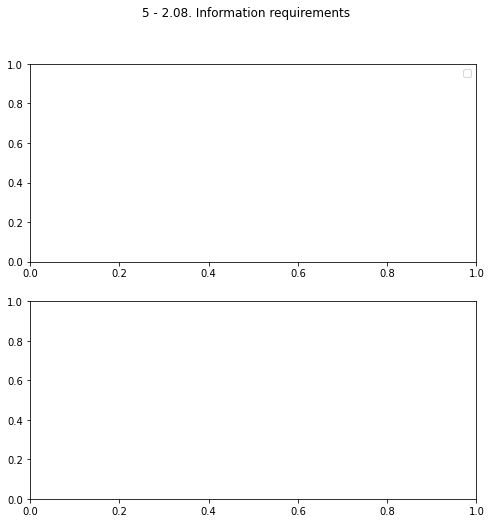

No handles with labels found to put in legend.


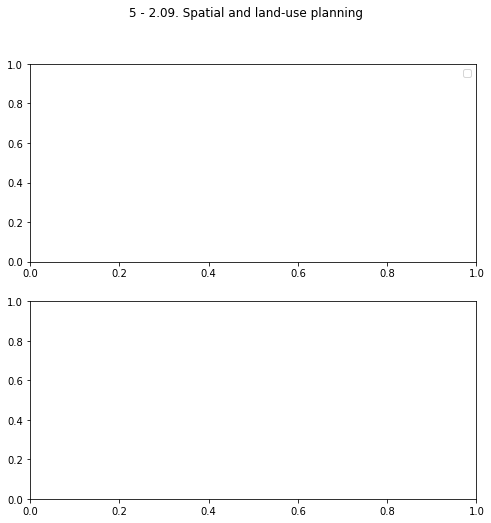

No handles with labels found to put in legend.


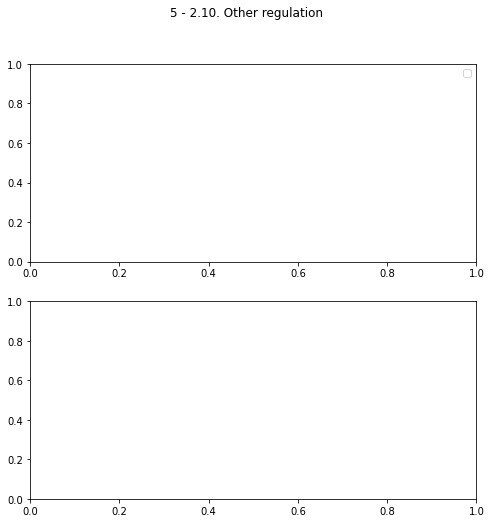

No handles with labels found to put in legend.


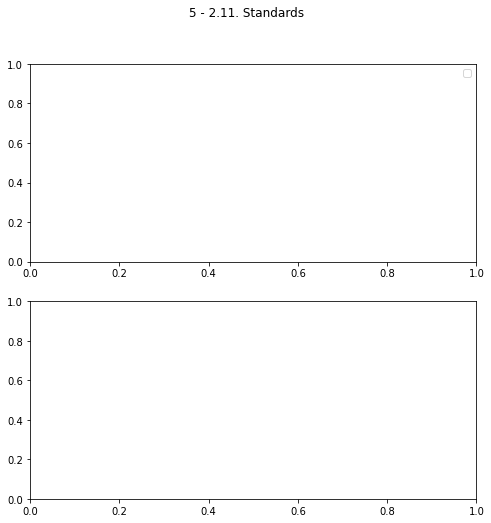

No handles with labels found to put in legend.


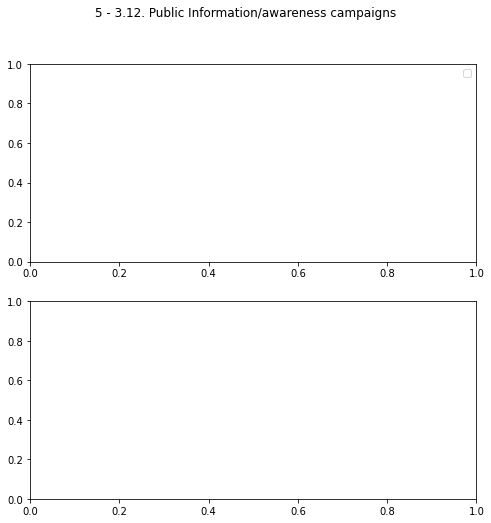

No handles with labels found to put in legend.


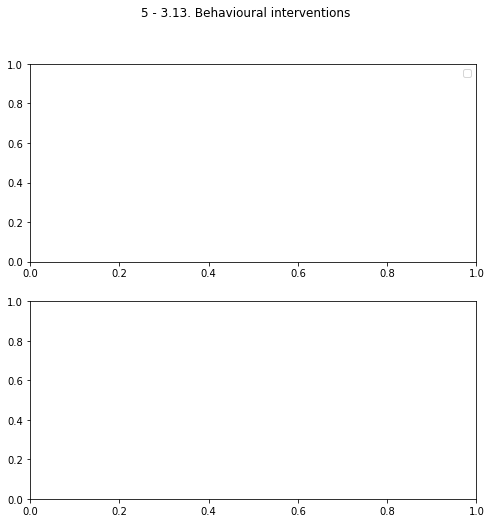

No handles with labels found to put in legend.


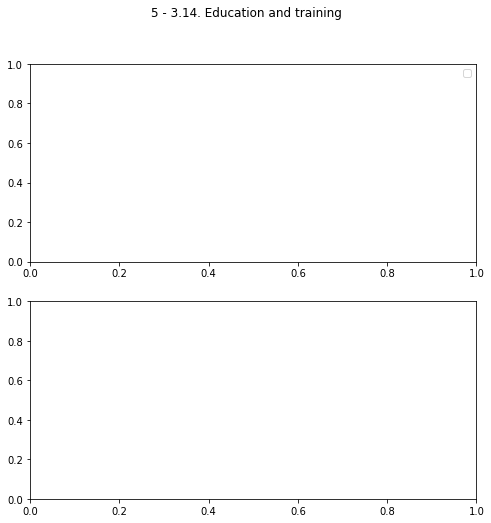

No handles with labels found to put in legend.


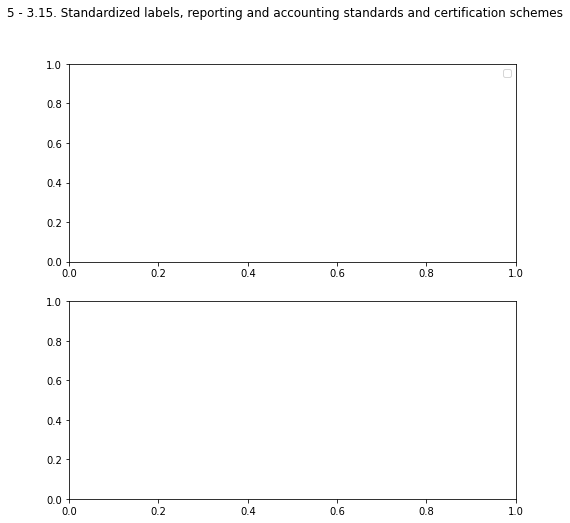

No handles with labels found to put in legend.


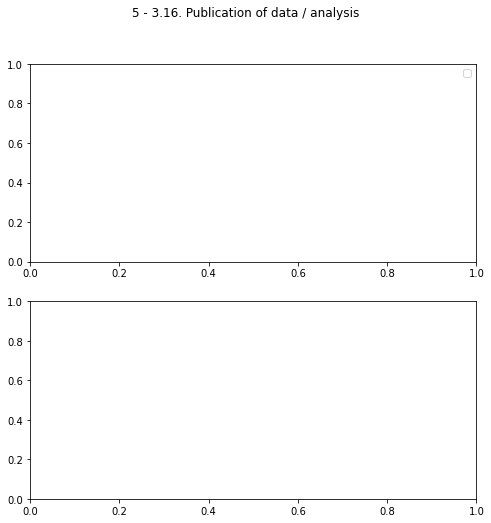

No handles with labels found to put in legend.


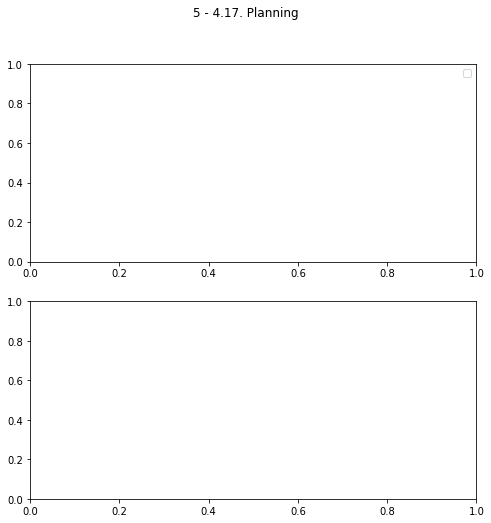

No handles with labels found to put in legend.


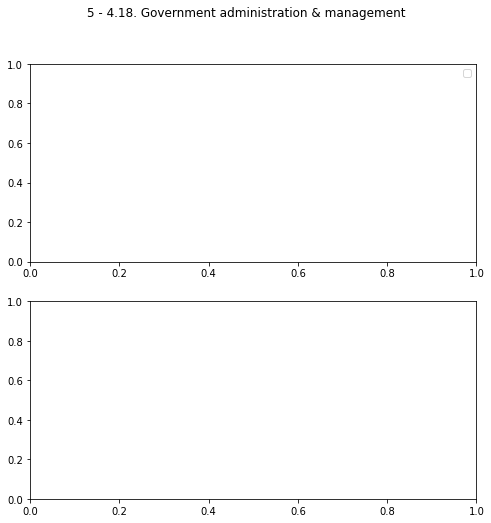

No handles with labels found to put in legend.


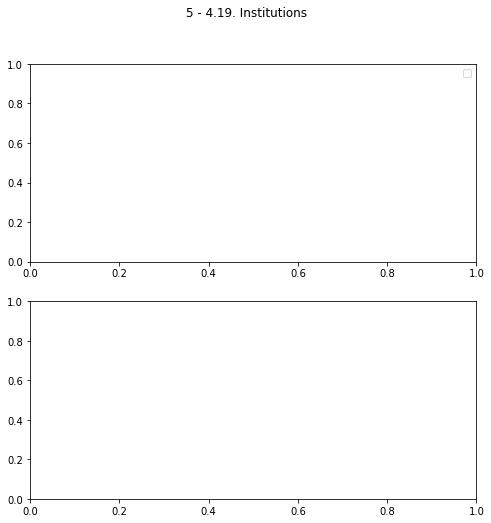

No handles with labels found to put in legend.


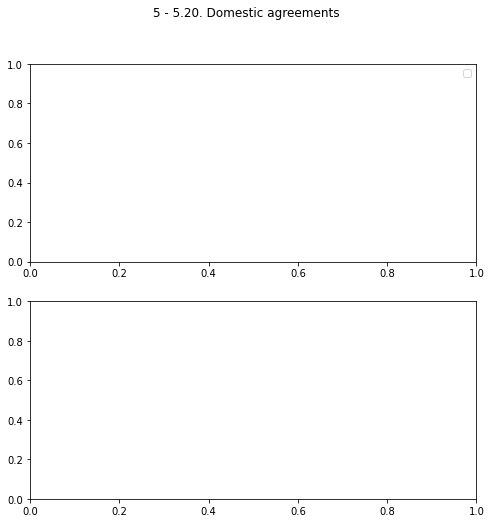

No handles with labels found to put in legend.


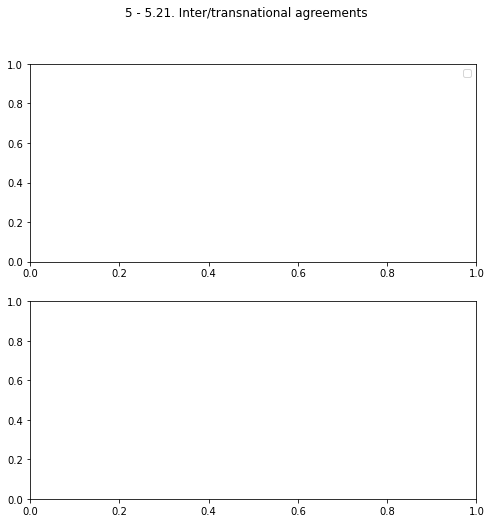

No handles with labels found to put in legend.


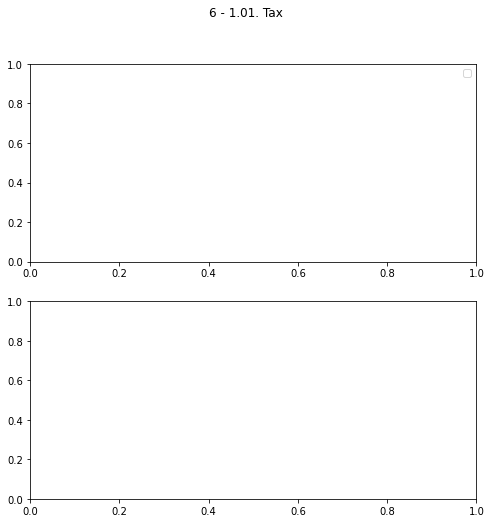

No handles with labels found to put in legend.


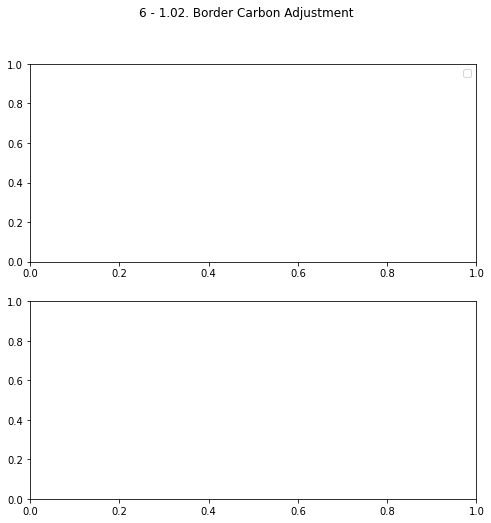

No handles with labels found to put in legend.


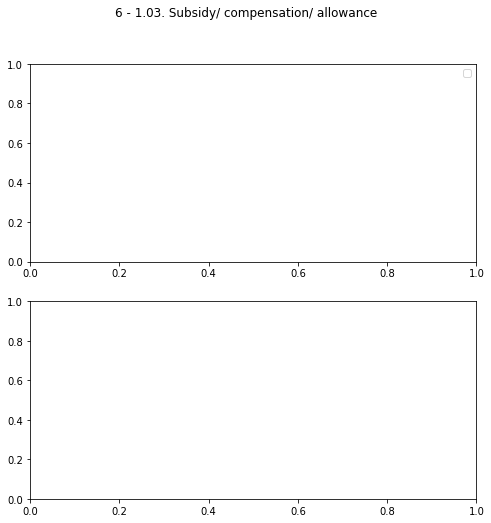

No handles with labels found to put in legend.


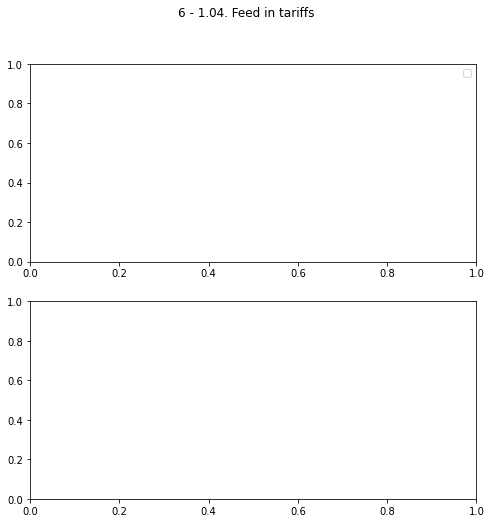

No handles with labels found to put in legend.


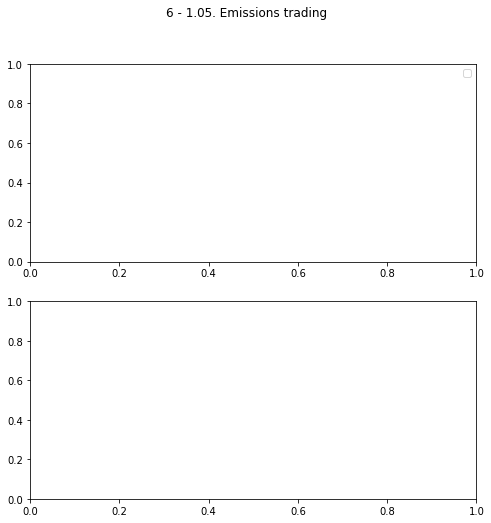

No handles with labels found to put in legend.


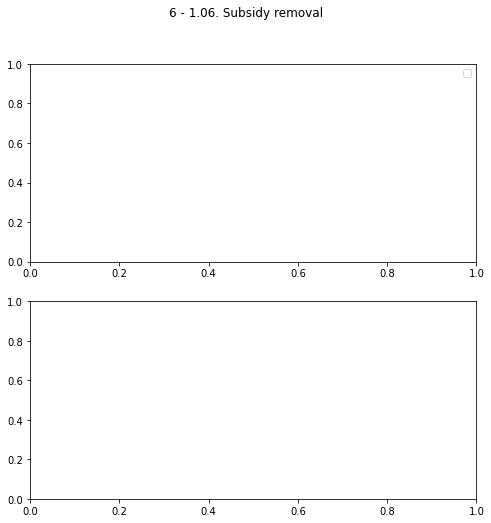

No handles with labels found to put in legend.


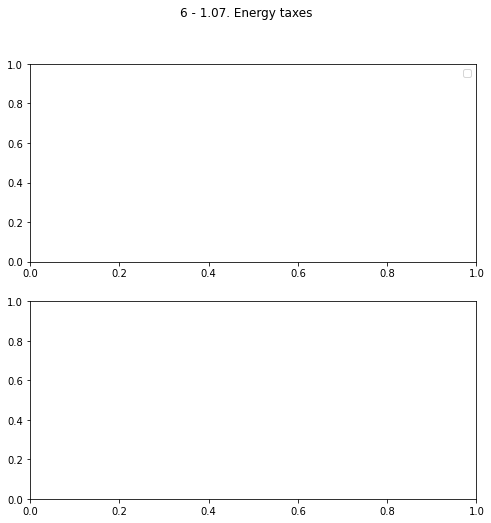

No handles with labels found to put in legend.


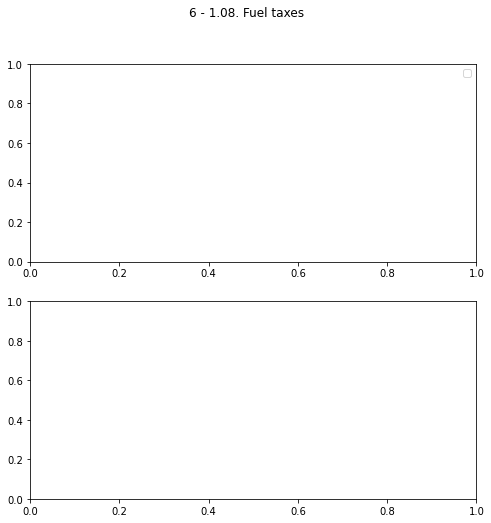

No handles with labels found to put in legend.


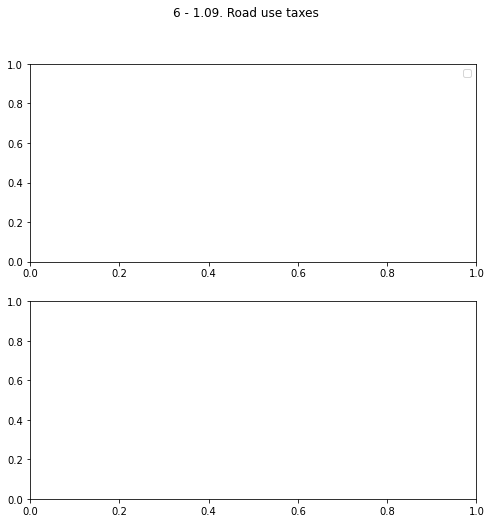

No handles with labels found to put in legend.


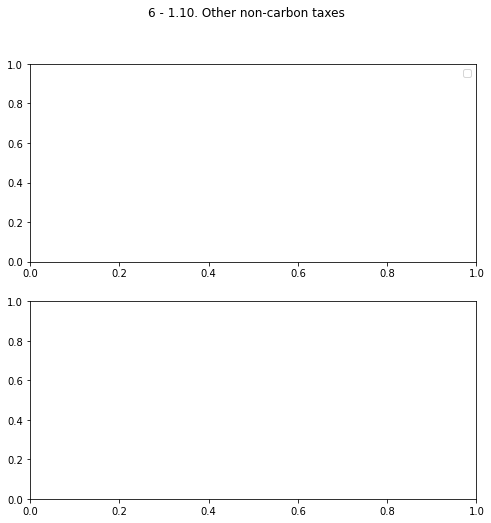

No handles with labels found to put in legend.


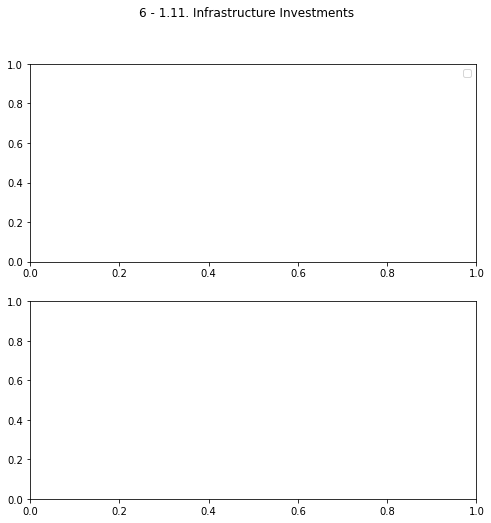

No handles with labels found to put in legend.


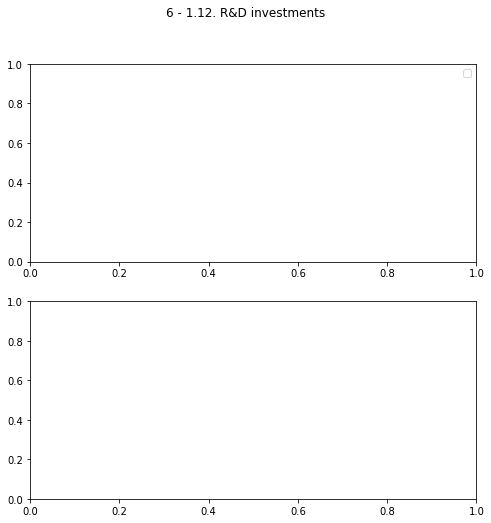

No handles with labels found to put in legend.


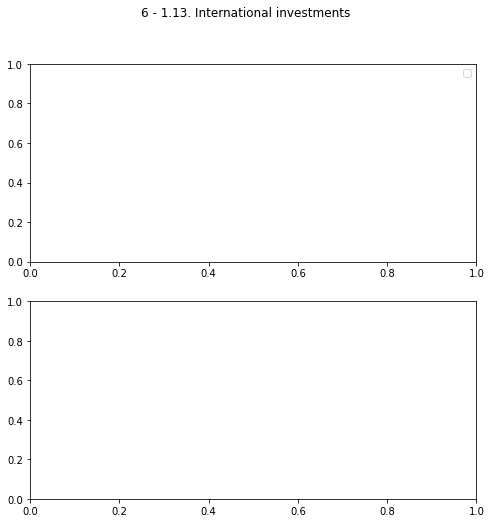

No handles with labels found to put in legend.


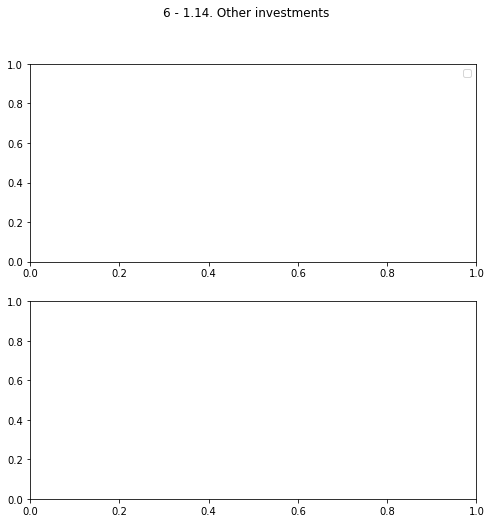

No handles with labels found to put in legend.


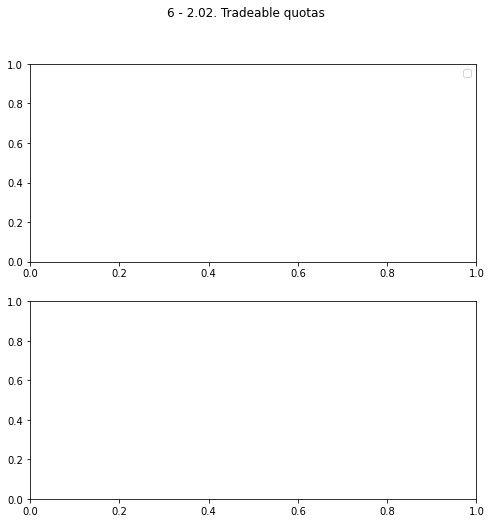

No handles with labels found to put in legend.


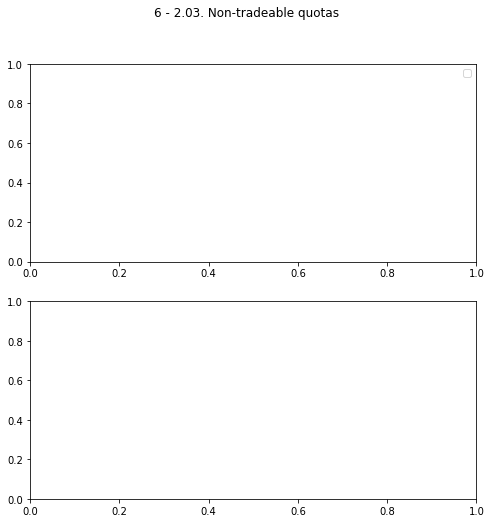

No handles with labels found to put in legend.


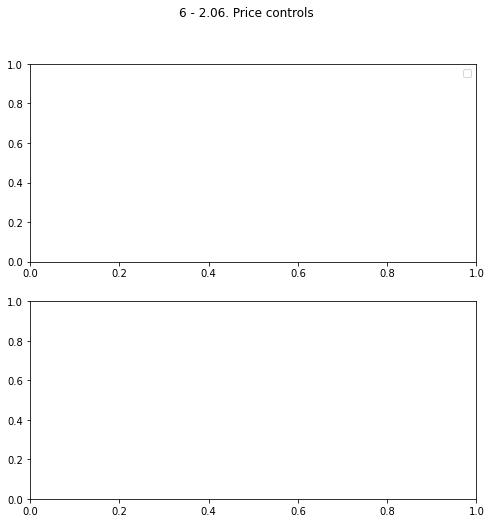

No handles with labels found to put in legend.


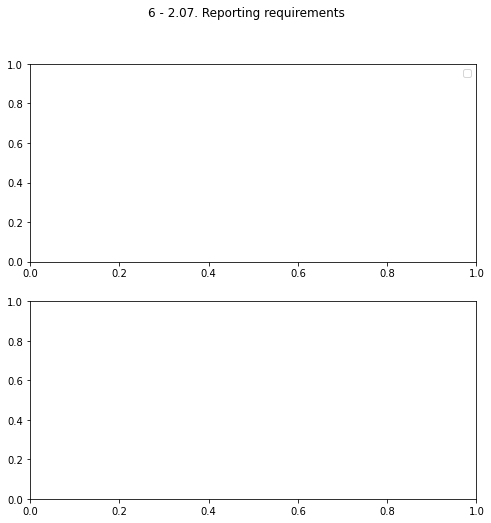

No handles with labels found to put in legend.


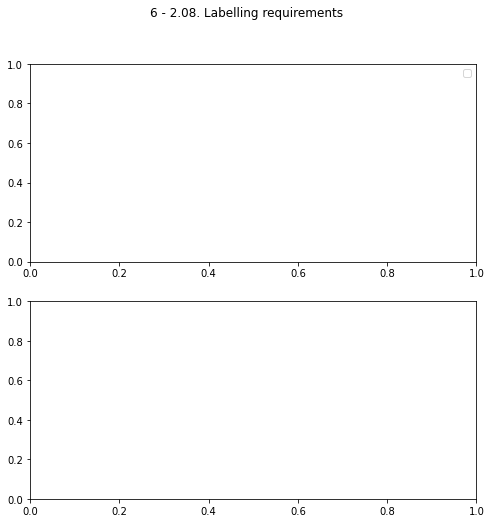

No handles with labels found to put in legend.


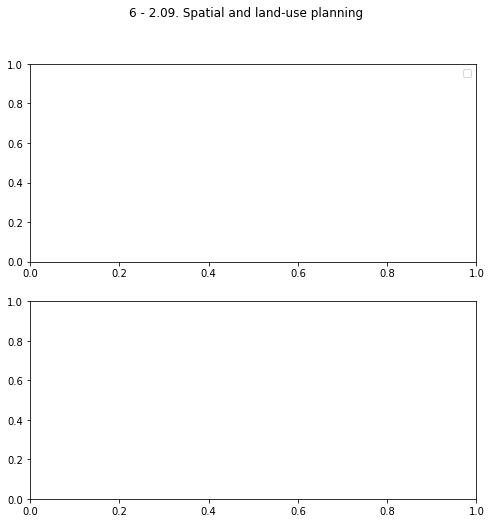

No handles with labels found to put in legend.


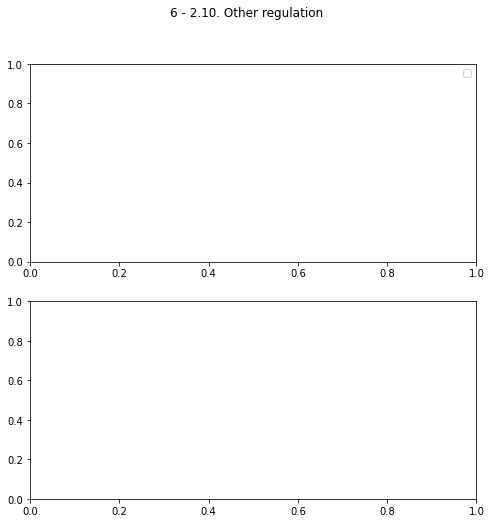

No handles with labels found to put in legend.


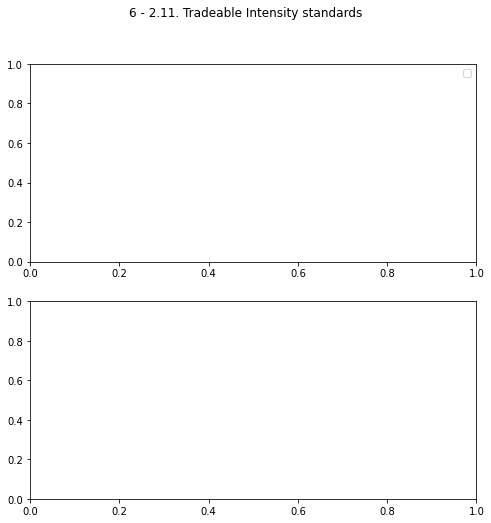

No handles with labels found to put in legend.


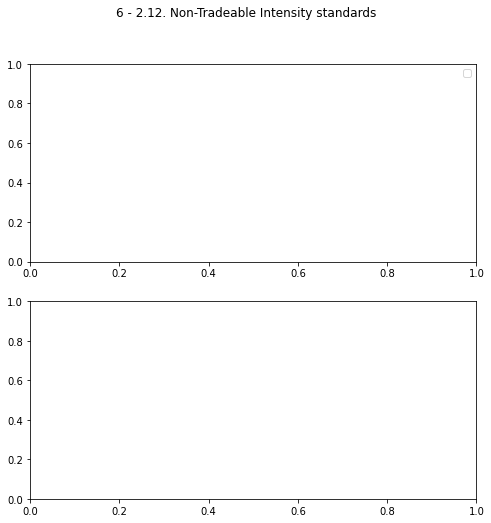

No handles with labels found to put in legend.


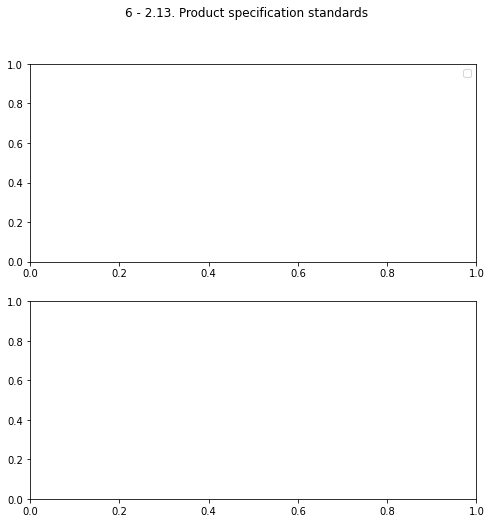

No handles with labels found to put in legend.


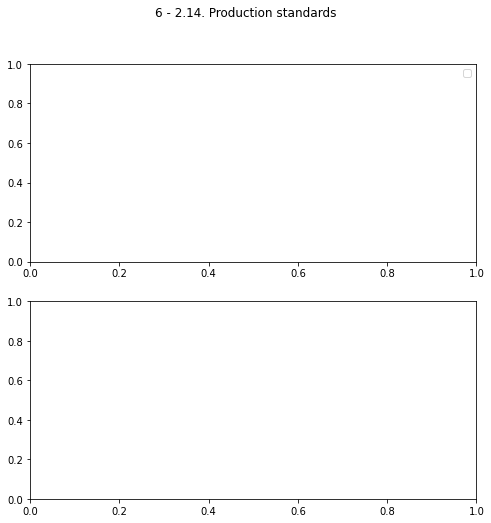

No handles with labels found to put in legend.


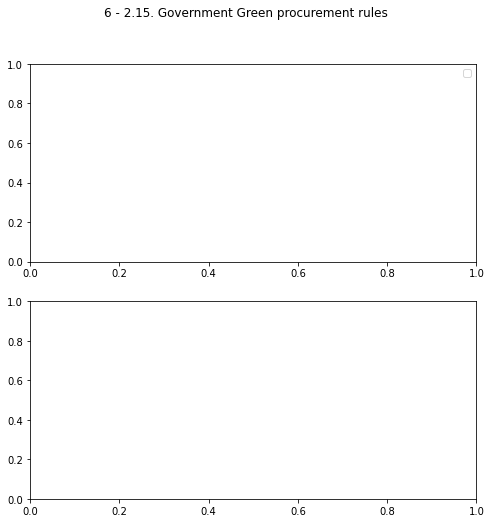

No handles with labels found to put in legend.


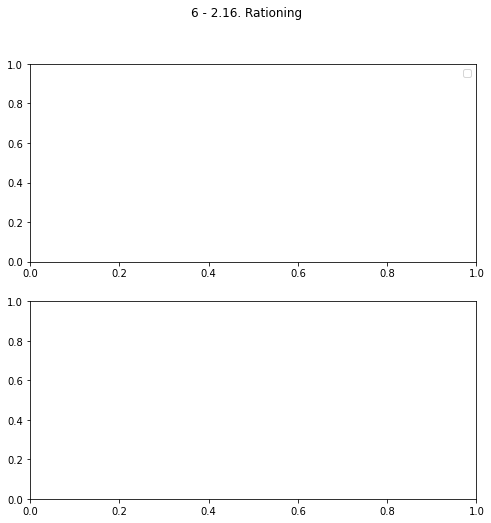

No handles with labels found to put in legend.


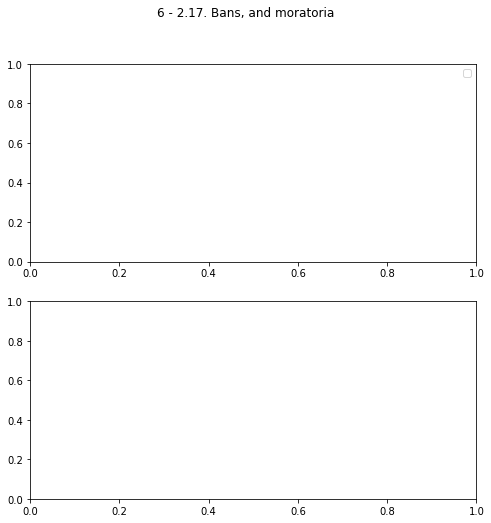

No handles with labels found to put in legend.


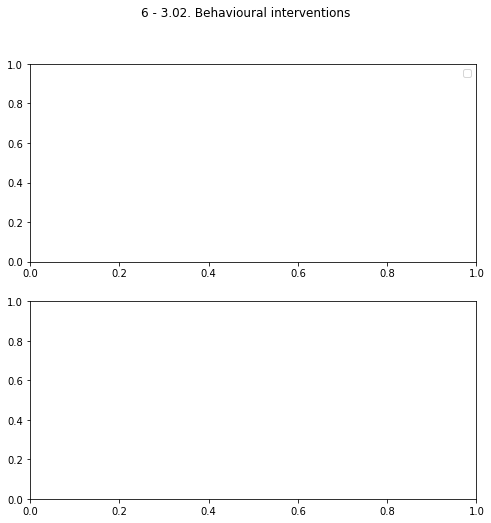

No handles with labels found to put in legend.


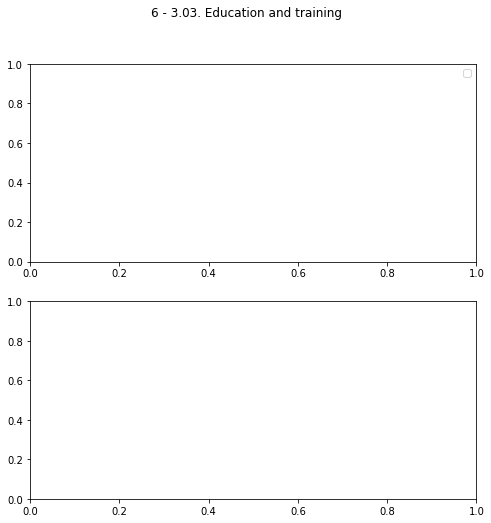

No handles with labels found to put in legend.


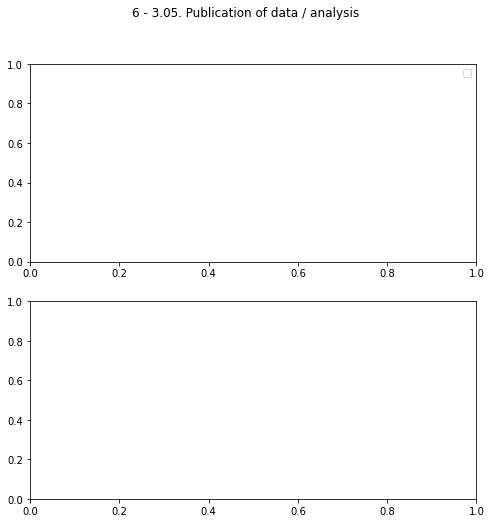

No handles with labels found to put in legend.


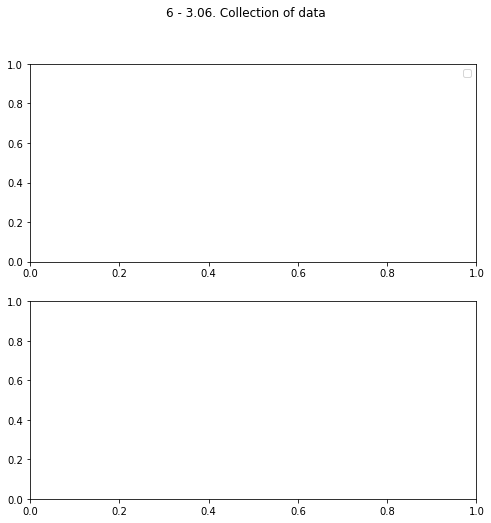

No handles with labels found to put in legend.


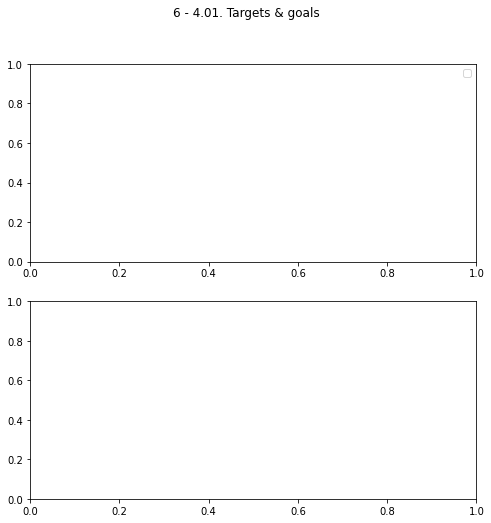

No handles with labels found to put in legend.


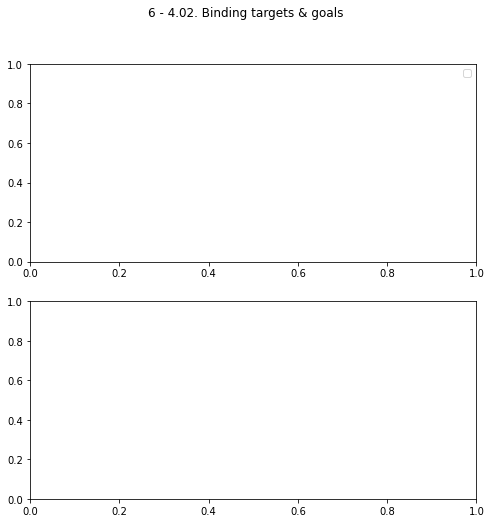

No handles with labels found to put in legend.


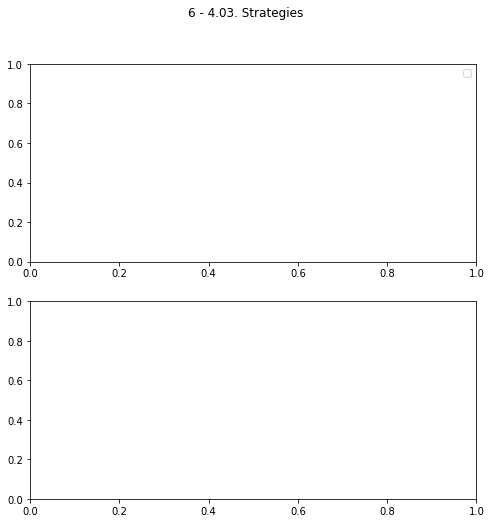

No handles with labels found to put in legend.


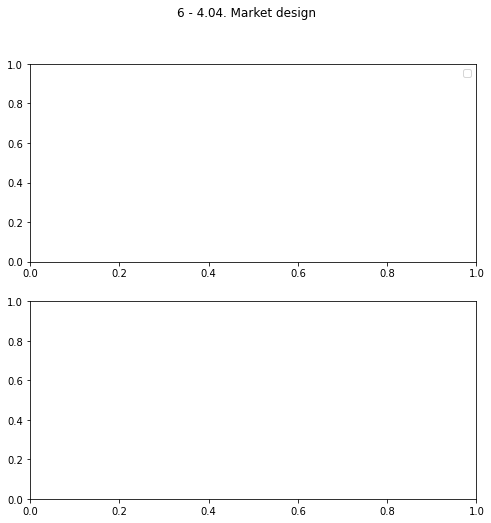

No handles with labels found to put in legend.


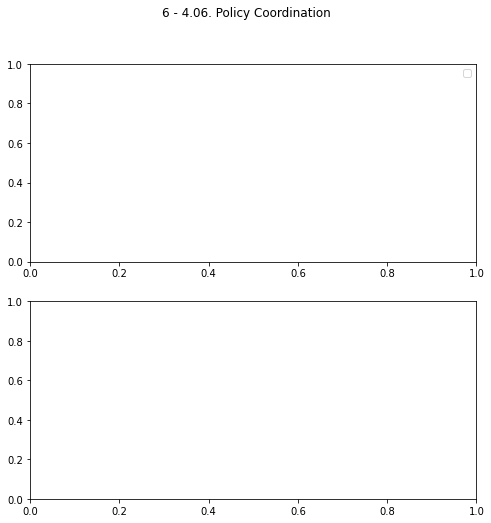

No handles with labels found to put in legend.


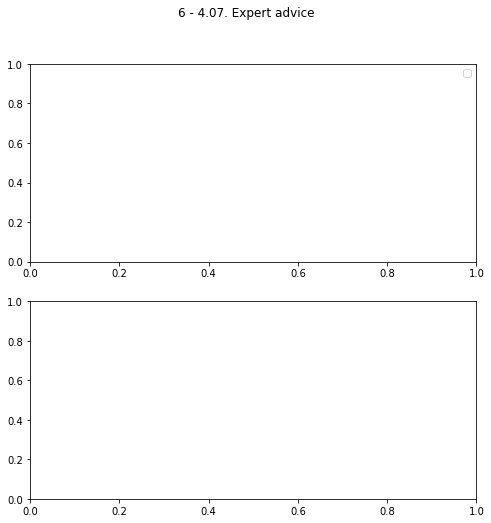

No handles with labels found to put in legend.


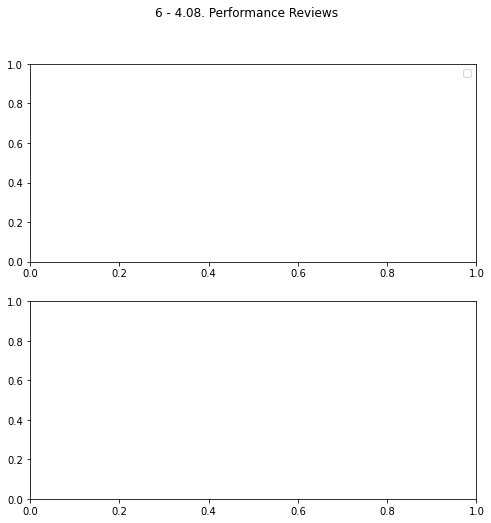

No handles with labels found to put in legend.


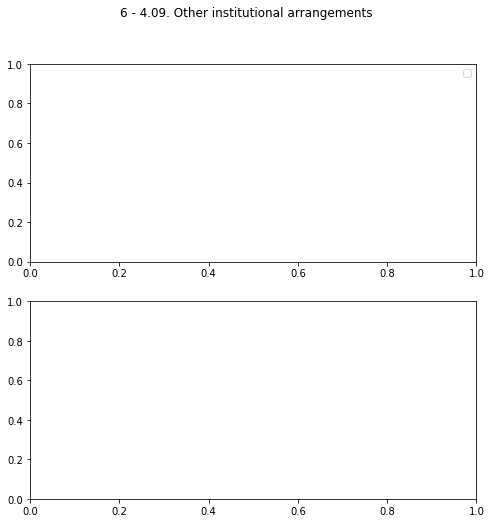

No handles with labels found to put in legend.


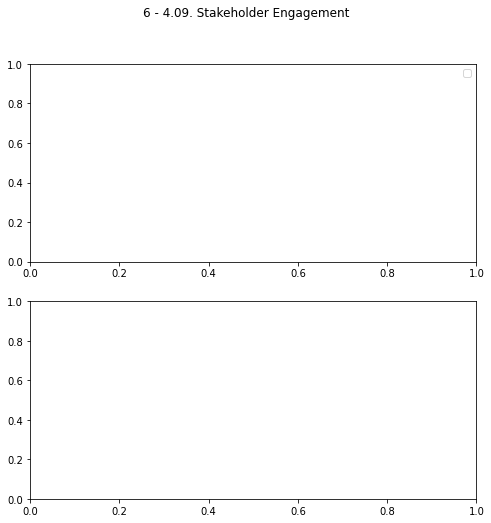

No handles with labels found to put in legend.


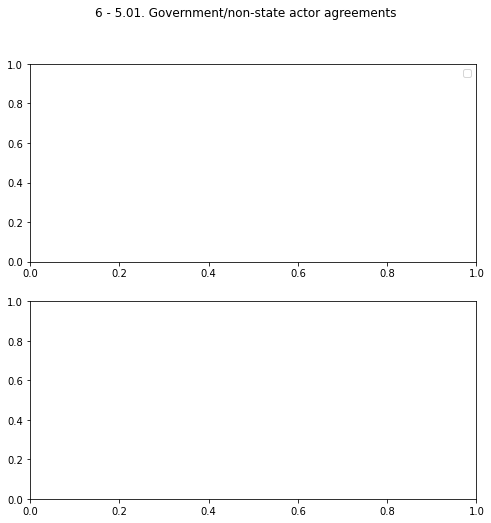

No handles with labels found to put in legend.


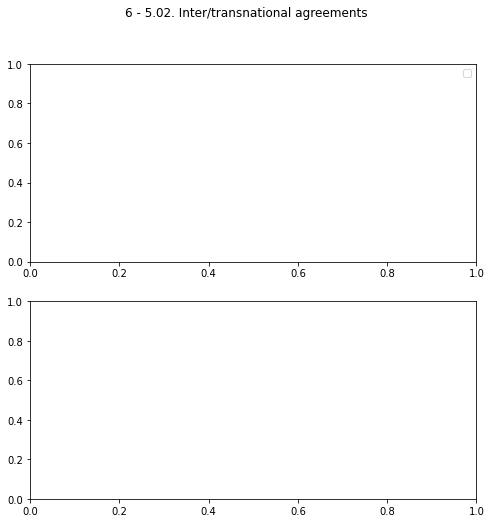

No handles with labels found to put in legend.


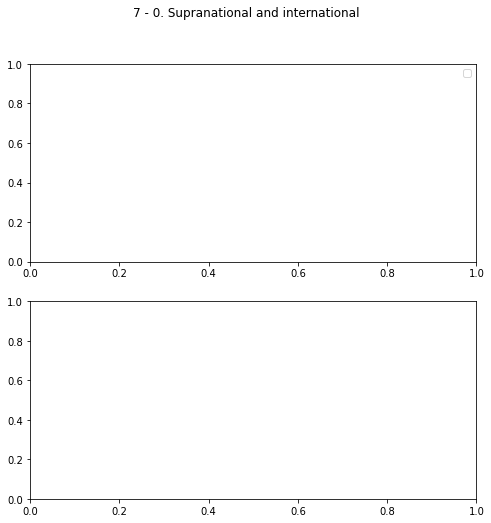

No handles with labels found to put in legend.


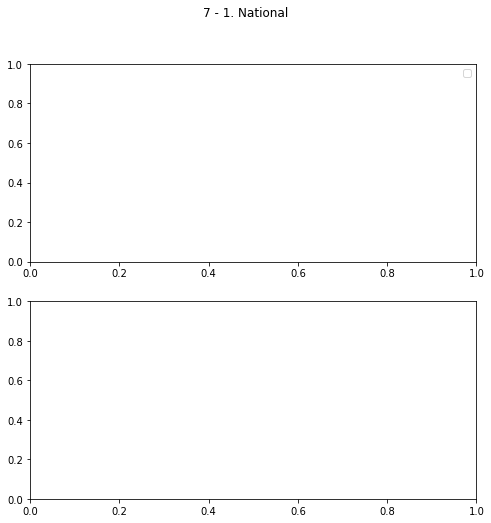

No handles with labels found to put in legend.


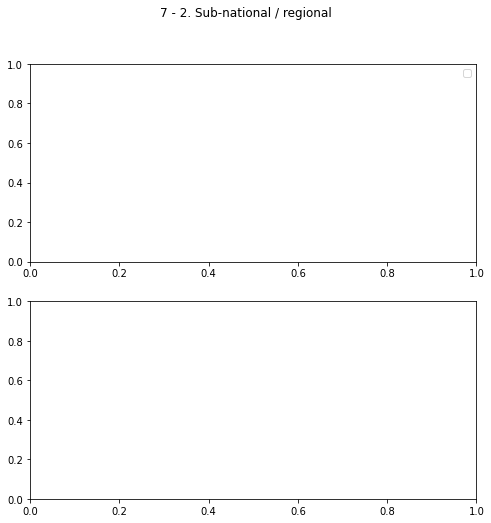

No handles with labels found to put in legend.


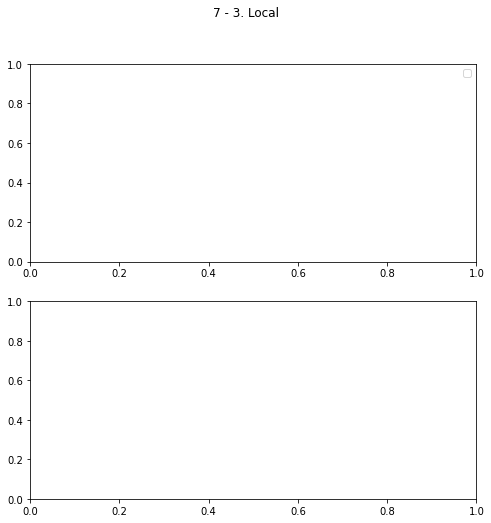

No handles with labels found to put in legend.


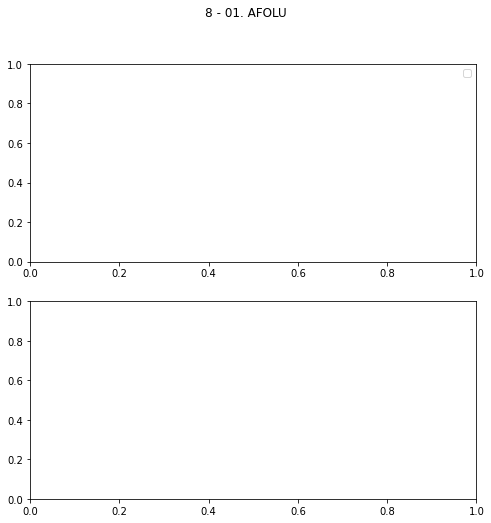

No handles with labels found to put in legend.


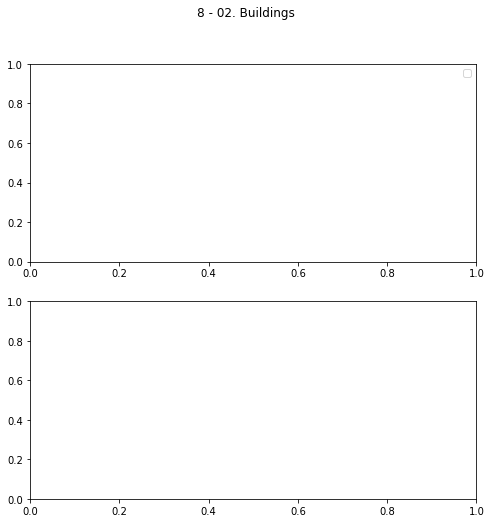

No handles with labels found to put in legend.


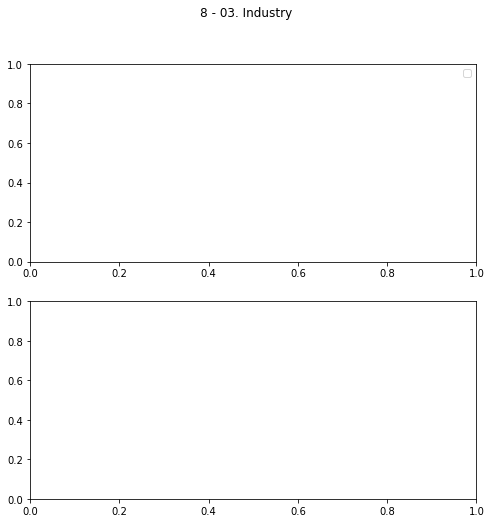

No handles with labels found to put in legend.


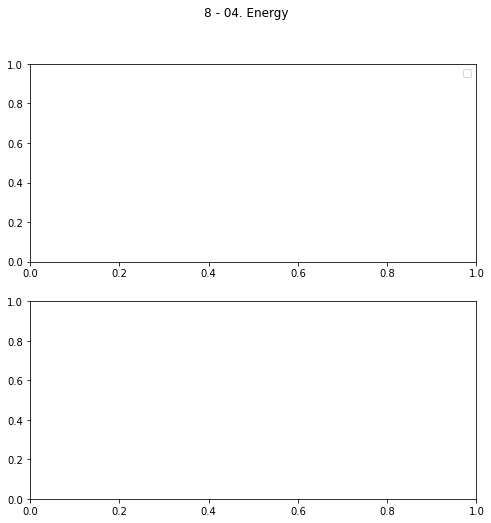

No handles with labels found to put in legend.


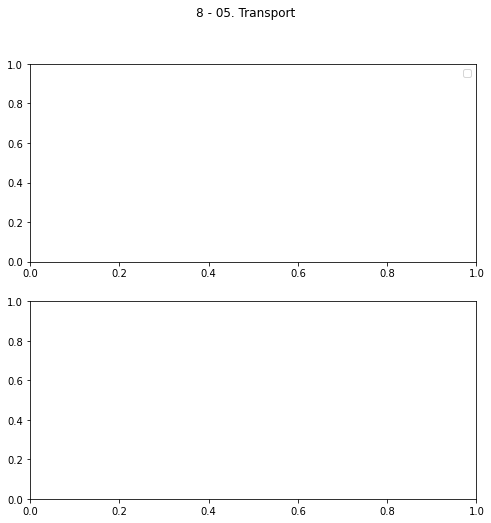

No handles with labels found to put in legend.


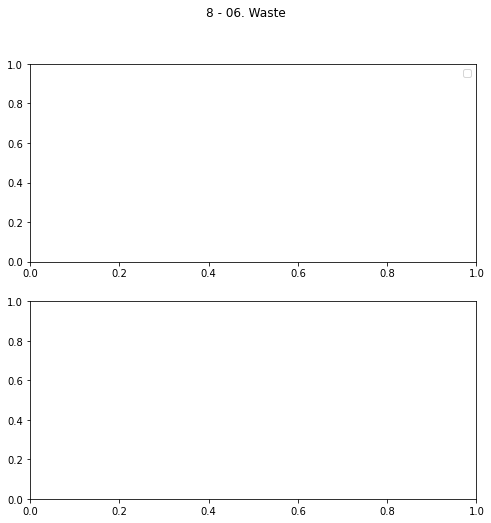

No handles with labels found to put in legend.


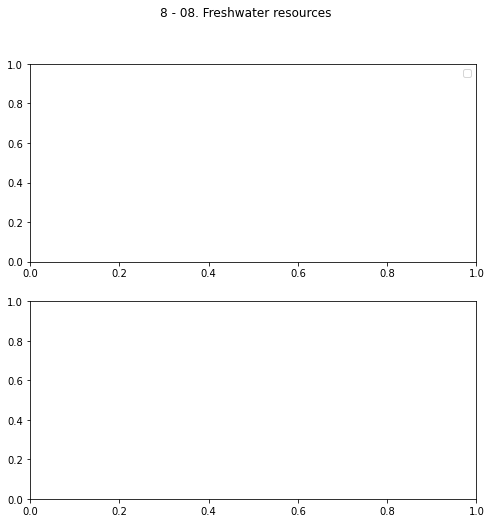

No handles with labels found to put in legend.


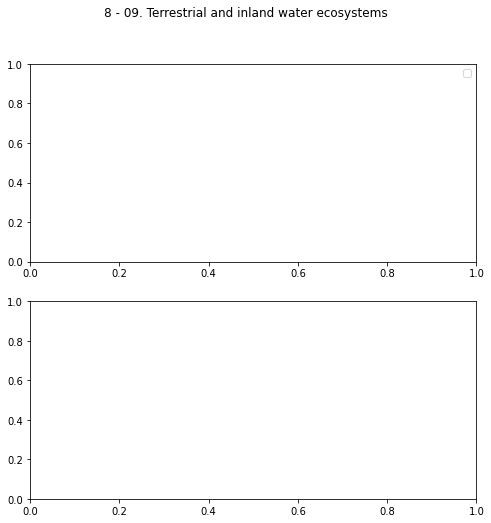

No handles with labels found to put in legend.


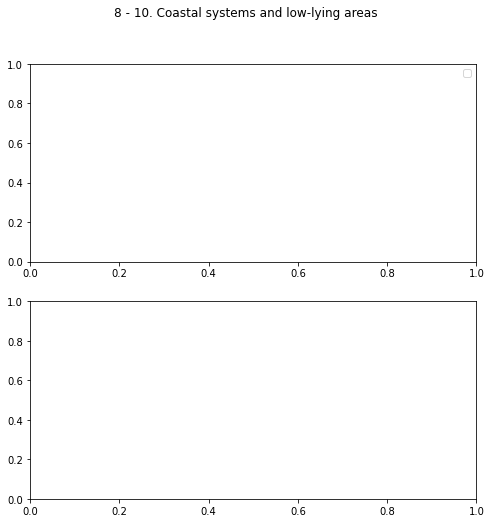

No handles with labels found to put in legend.


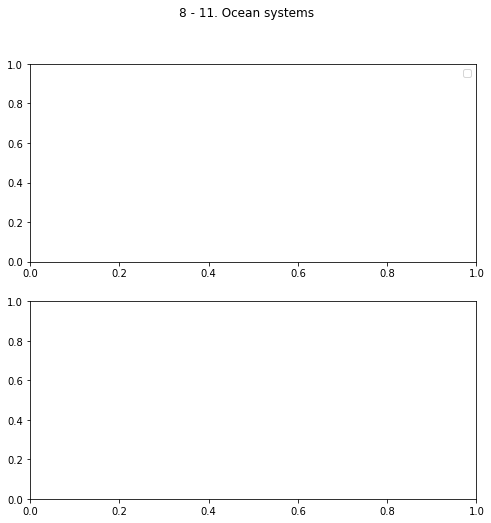

No handles with labels found to put in legend.


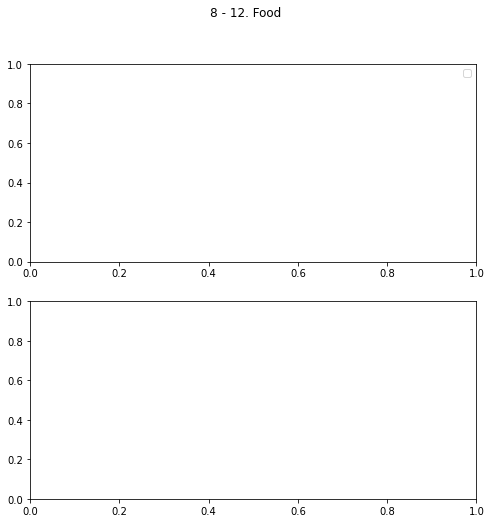

No handles with labels found to put in legend.


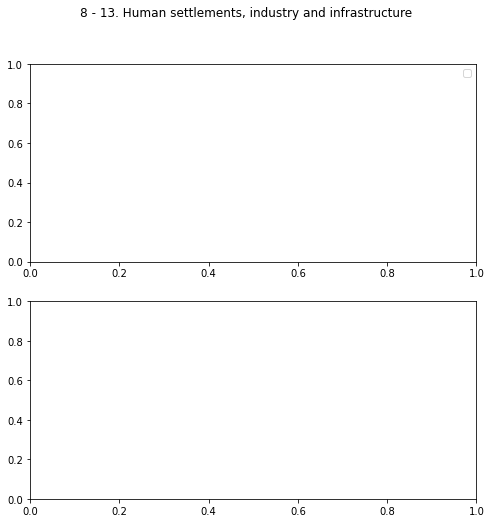

No handles with labels found to put in legend.


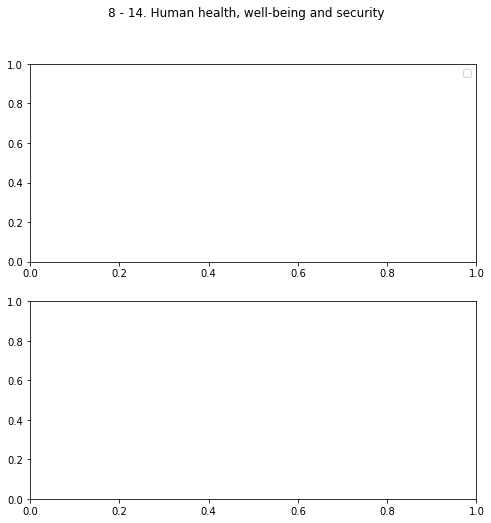

No handles with labels found to put in legend.


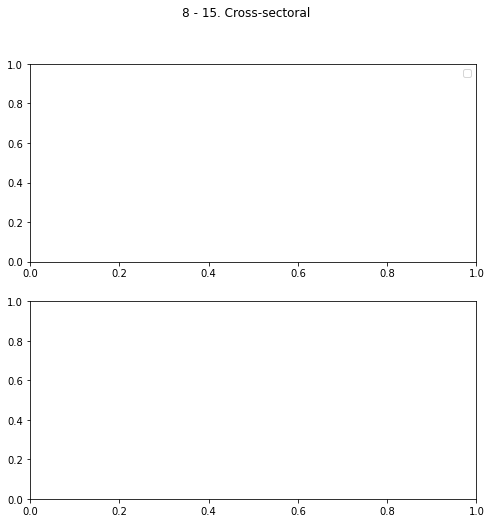

No handles with labels found to put in legend.


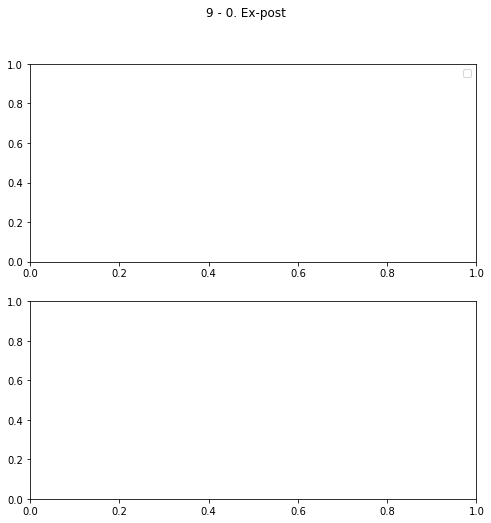

No handles with labels found to put in legend.


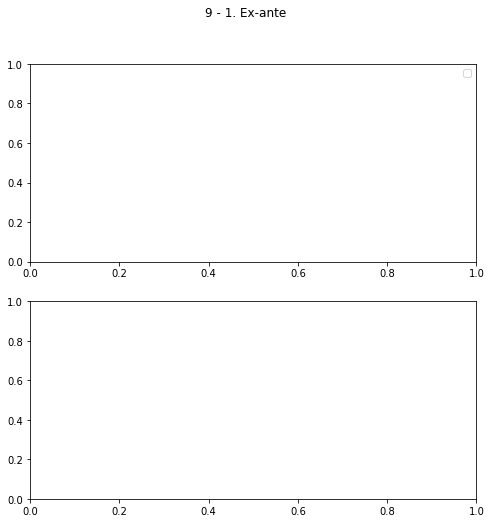

No handles with labels found to put in legend.


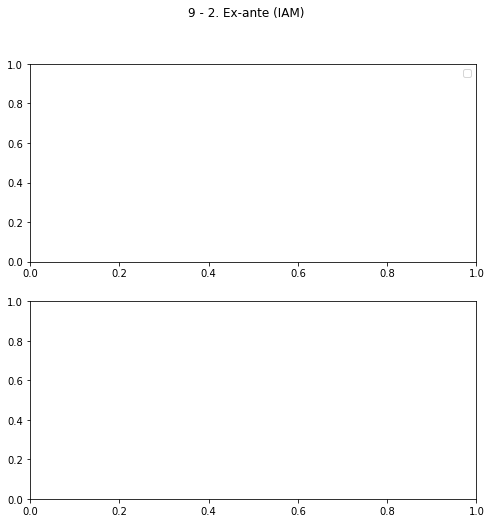

No handles with labels found to put in legend.


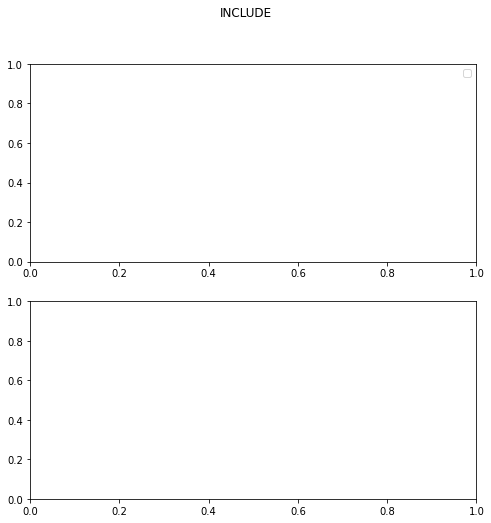

In [23]:
import itertools
pairs = list(itertools.combinations(dodf['user__username'].unique(),2))
pairs
from sklearn.metrics import cohen_kappa_score
from numpy_ext import rolling_apply as rolling_apply_ext
ckfunc = lambda a1, a2: cohen_kappa_score(a1,a2)

for c in list(df['Category Name'].unique()):
    
    sub_df = df[df['Category Name']==c].dropna(subset=["value"])
    sub_df.loc[sub_df["value"]==2,"value"]=1
    
    try:
        sub_df["value"].astype(int)
    except:
        print(c)
        continue
        
    fig, axs = plt.subplots(2,figsize=(8,8)) 

    i = 0

    for p in pairs:
        
        d1 = sub_df[(sub_df['user__username']==p[0]) & (sub_df['Category Name']==c)].rename(columns={"value":p[0]}).drop(columns="user__username")
        d2 = sub_df[(sub_df['user__username']==p[1]) & (sub_df['Category Name']==c)].rename(columns={"value":p[1]}).drop(columns="user__username")

        pdf = (d1.merge(d2,how="inner")
               .merge(order_df,left_on="doc__id",right_on="doc_id")
               .sort_values('order')
               .reset_index(drop=True)
               .fillna(1)
              )


        if pdf.shape[0]<50:
            continue
        else:
            
            ckr = rolling_apply_ext(ckfunc, 50, pdf[p[0]].astype(int).values, pdf[p[1]].astype(int).values)
            axs[0].plot(ckr,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
            ck = cohen_kappa_score(pdf[p[0]],pdf[p[1]])
            axs[1].bar(i,ck,label=f"{p[0].split('@')[0]}-{p[1].split('@')[0]}")
            i+=1
            axs[0].set_ylim(-1,1)

            for ax in axs:
                ax.set_ylim(0,1)
                for t,ag in [(0,"None"),(0.2,"Minimal"),(0.4,"Weak"),(0.6,"Moderate"),(0.8,"Strong"),(0.9,"Almost Perfect")]:
                    ax.axhline(t,color="grey",ls="--",lw=0.5)


    axs[0].legend(bbox_to_anchor=(1,1))
    plt.suptitle(c)
    plt.show()